In [ ]:
!pip install kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"juhyeongki","key":"10349ac77376875bb9486e3c2011bf31"}'}

In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
! kaggle competitions download -c house-prices-advanced-regression-techniques

import pandas as pd
import numpy as np
import seaborn as sns

train = pd.read_csv('/content/train.csv',index_col=0)
test = pd.read_csv('/content/test.csv',index_col=0)
sample_submission = pd.read_csv('/content/sample_submission.csv')

train.csv: Skipping, found more recently modified local copy (use --force to force download)
sample_submission.csv: Skipping, found more recently modified local copy (use --force to force download)
test.csv: Skipping, found more recently modified local copy (use --force to force download)
data_description.txt: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
## Kaggle에 있는 BOSTON 집 값 예측에 대한 dataset을 불러왔습니다.

## train, test의 sample수가 부족한 모습을 확인 할 수 있습니다.
## 또한 test셋에는 target인 'SalesPrice' 이 제거되어 있는 것을 볼 수 있습니다.

In [ ]:
## 먼저 feature들을 잘 활용하기 위해서 feature들의 분포, 상관관계를 확인하고 시각화 해보도록 하겠습니다.

In [2]:
train.shape, test.shape, sample_submission.shape

((1460, 80), (1459, 79), (1459, 2))

In [3]:
train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 1 to 1460
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

In [5]:
pd.set_option('display.max_rows', 500)

In [6]:
Baseline_before = train['SalePrice'].mean()
Baseline_before1 = np.log(train['SalePrice']).mean()

In [7]:
## MsZoning, LotShape, LandConfig, LandSlope, Neighborhood, Condition1, Bldgtype, HouseStyle, RoofStyle, Exterior1st, Exterior2nd, MasVnrType, Foundation, CentralAir, Electrical, Functional, GarageType, GarageFinish, PavedDrive, SaleType, SaleCondition
train.drop(['MSZoning','LandContour', 'LotShape', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'BldgType', 'HouseStyle', 'RoofStyle', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Foundation', 'CentralAir', 'Electrical', 'Functional', 'GarageType', 'GarageFinish', 'PavedDrive', 'SaleType', 'SaleCondition'],axis=1,inplace=True)
test.drop(['MSZoning','LandContour', 'LotShape', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'BldgType', 'HouseStyle', 'RoofStyle', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Foundation', 'CentralAir', 'Electrical', 'Functional', 'GarageType', 'GarageFinish', 'PavedDrive', 'SaleType', 'SaleCondition'],axis=1,inplace=True)

In [8]:
# categorical(nominal and ordinal) 특성과 numerical 순서형 (discrete and continuos) 특성이 많기 때문에 분리하여 EDA(탐색적 데이터 분석)를 진행하겠습니다.

from sklearn.compose import make_column_selector as selector


# 1. Numerical features (숫자형 특성)

numeric_cols = selector(dtype_exclude=['object','category'])
numeric_cols = numeric_cols(train)
numeric_cols.remove('MSSubClass') # building class 이므로 categorical feature에 넣을 예정
numeric_cols.remove('SalePrice') # target 특성은 제거함

# 1-1 Discrete (순서형 숫자)

discrete = ['OverallQual','OverallCond','BsmtFullBath','BsmtHalfBath','FullBath','HalfBath',
        'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'MoSold', 'YrSold']

# 1-2 Continuous (연속형 숫자)

continuous = []
for i in numeric_cols:
    if i not in discrete:
        continuous.append(i)

# 2. Categorical features (범주형 특성)

categori_cols = selector(dtype_include=['object','category'])
categori_cols = categori_cols(train)
categori_cols = categori_cols + ['MSSubClass']

# 2-1 ordinal (범주형 카테고리)

ordinal = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
       'BsmtFinType2', 'HeatingQC', 'KitchenQual', 'FireplaceQu', 'GarageQual', 'GarageCond','PoolQC', 'Fence']

# 2-2 nominal (일반 범주)

nominal = []
for i in categori_cols :
  if i not in ordinal:
      nominal.append(i)



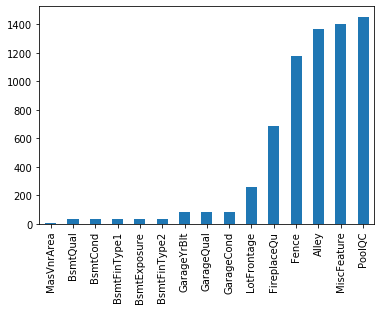

In [9]:
missing = train.isnull().sum()
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing.plot.bar()

## feature의 결측치를 확인해본 결과 총 15개의 feature에서 결측치가 확인 되었습니다.

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

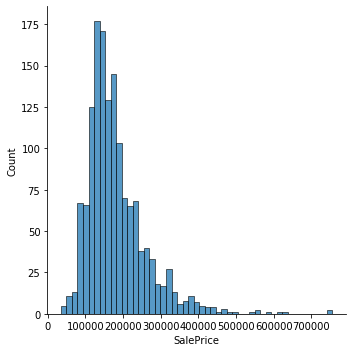

In [11]:
## target의 분포에 대해 확인해 보겠습니다.
## right-skewed 된 data 이므로 'SalePrice > 500000' 이상의 가격을 삭제하고 log-transform하겠습니다.

target = 'SalePrice'
sns.displot(train[target]);

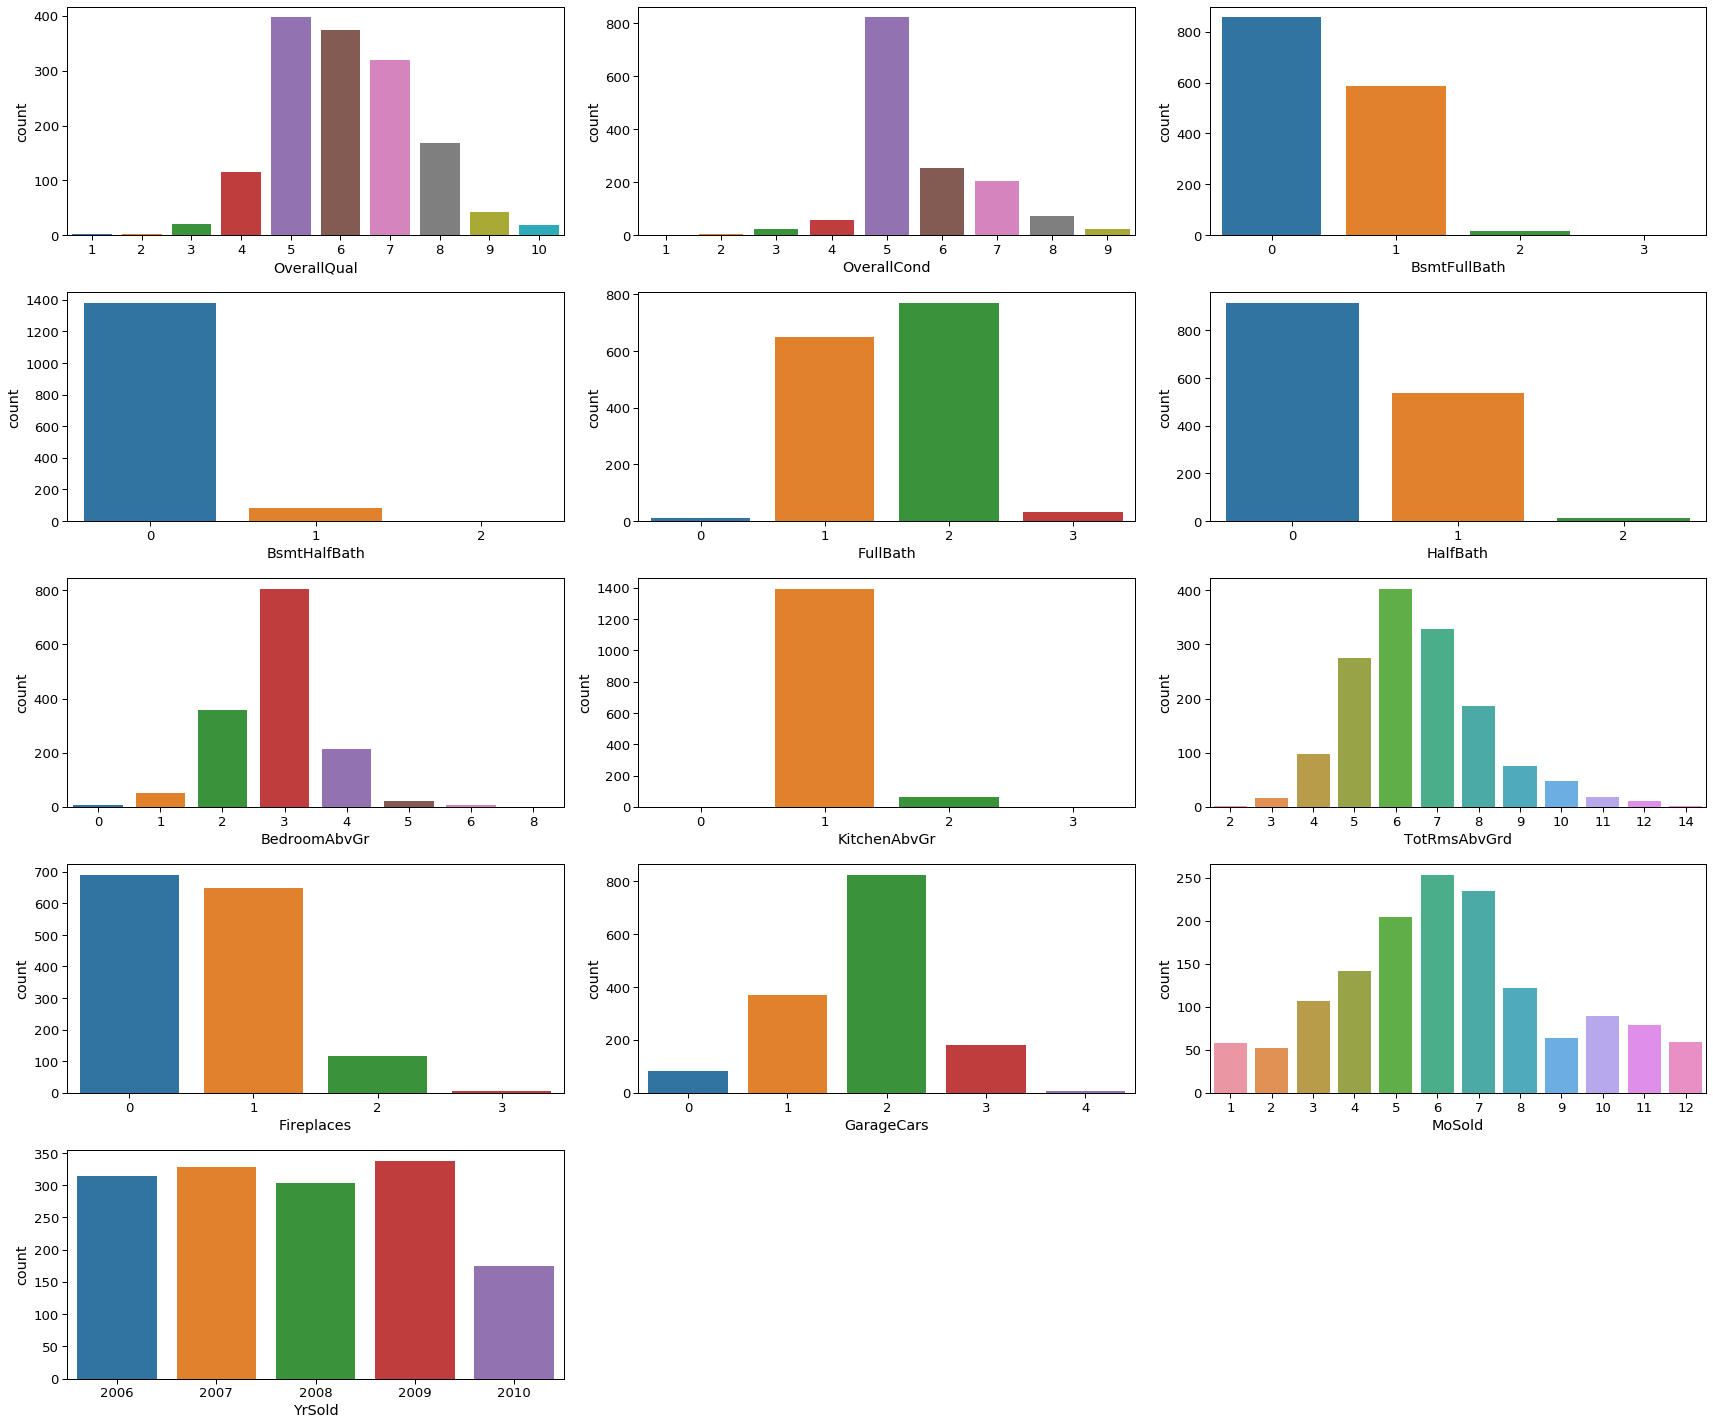

In [12]:
## Numeric : Discrete feature에 대해 분포를 확인해 보겠습니다.

sns.set_context('paper',font_scale=1.5)
fig = plt.figure(figsize=(24,20))

for index,col in enumerate(discrete):
    plt.subplot(5,3,index+1)
    sns.countplot(x=col, data=train)
fig.tight_layout(pad=1.0)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


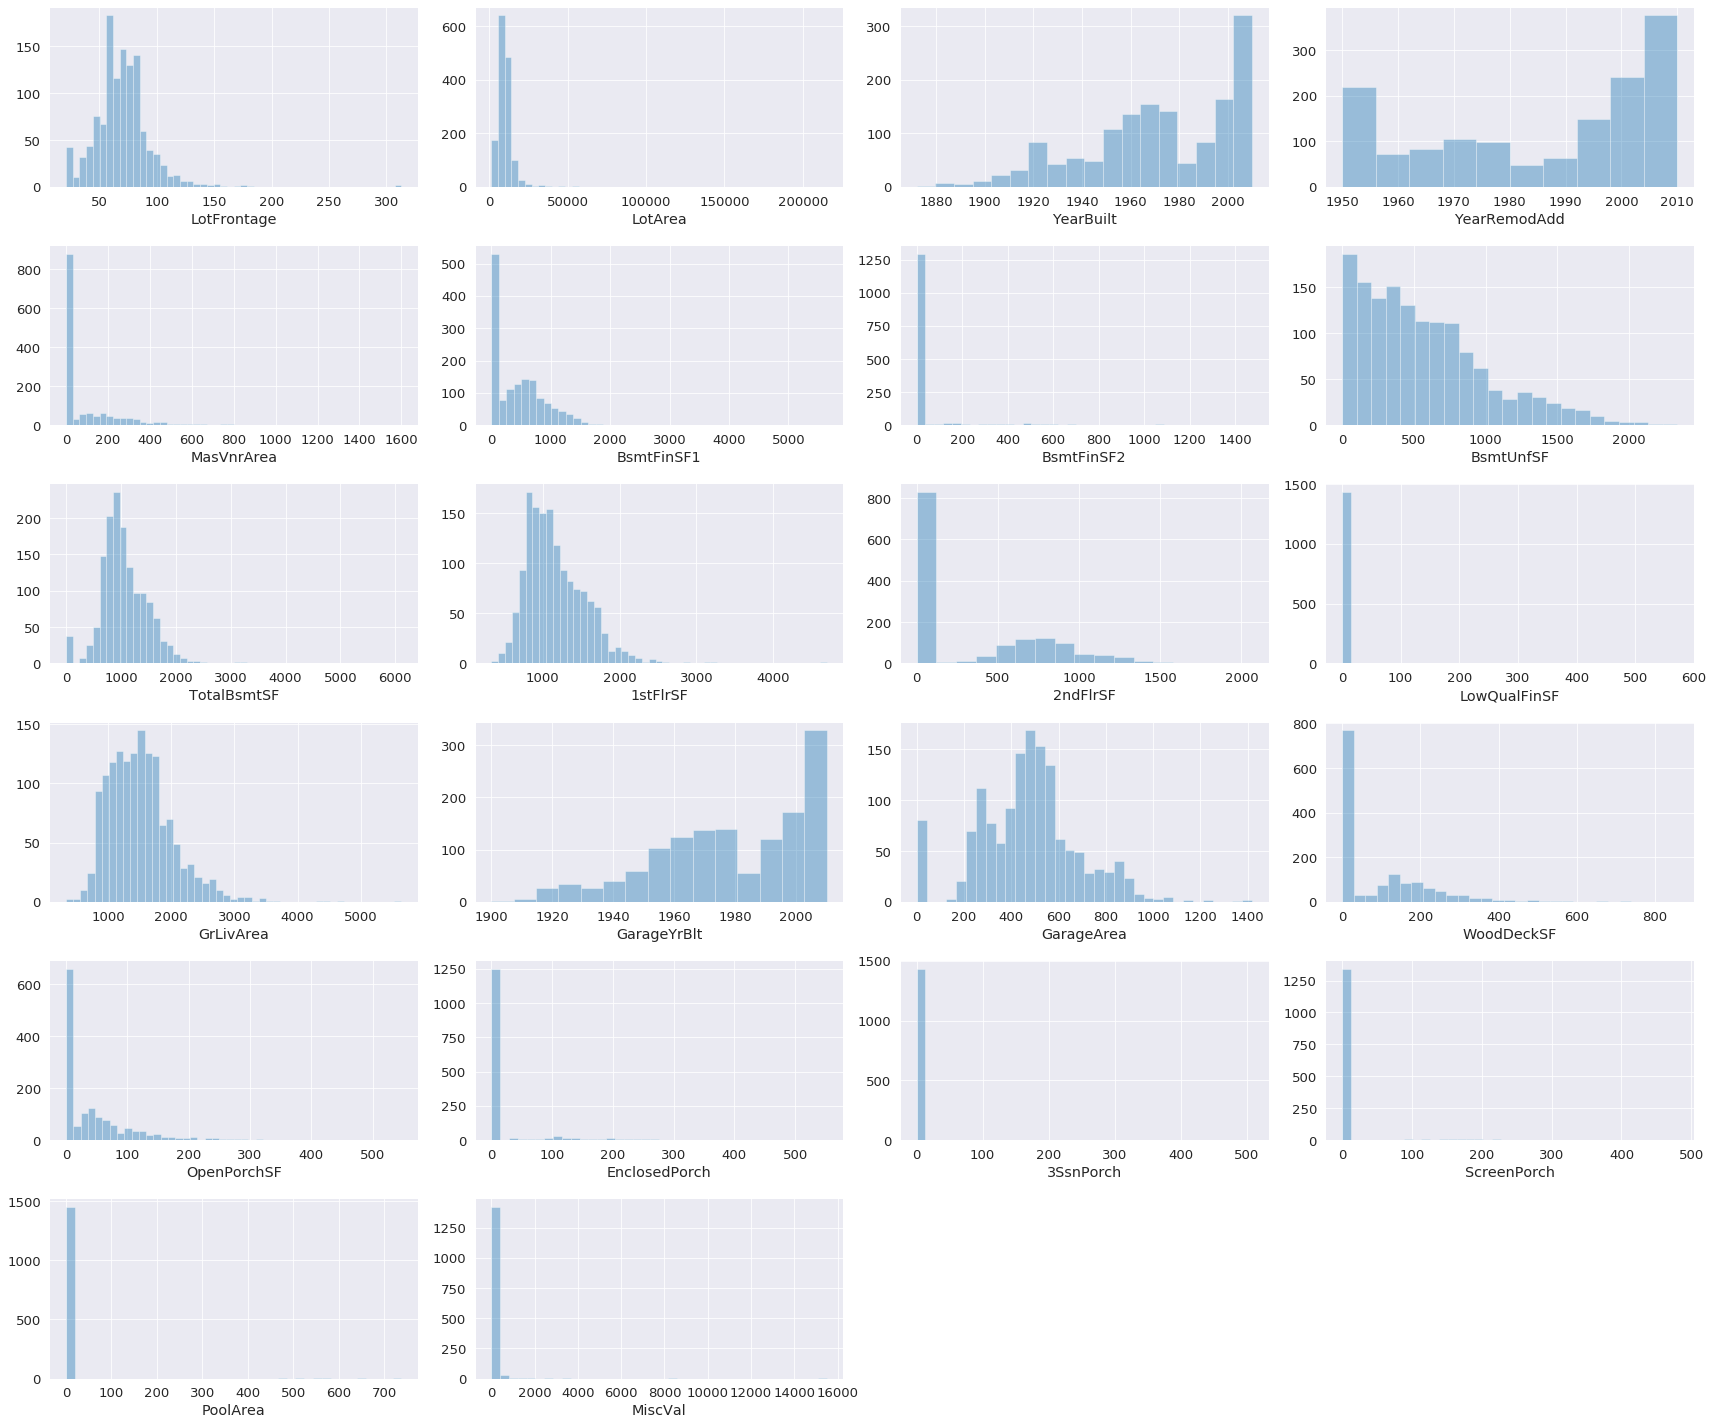

In [13]:
## Numeric : continuous feature에 대해 분포를 확인해 보겠습니다.

sns.set_style('darkgrid')
fig = plt.figure(figsize=(24,20))

for index, col in enumerate(continuous):
    plt.subplot(6,4,index+1)
    sns.distplot(train.loc[:,col],kde=False)
fig.tight_layout(pad=1.0)
sns.set_context('paper',font_scale=1.5)

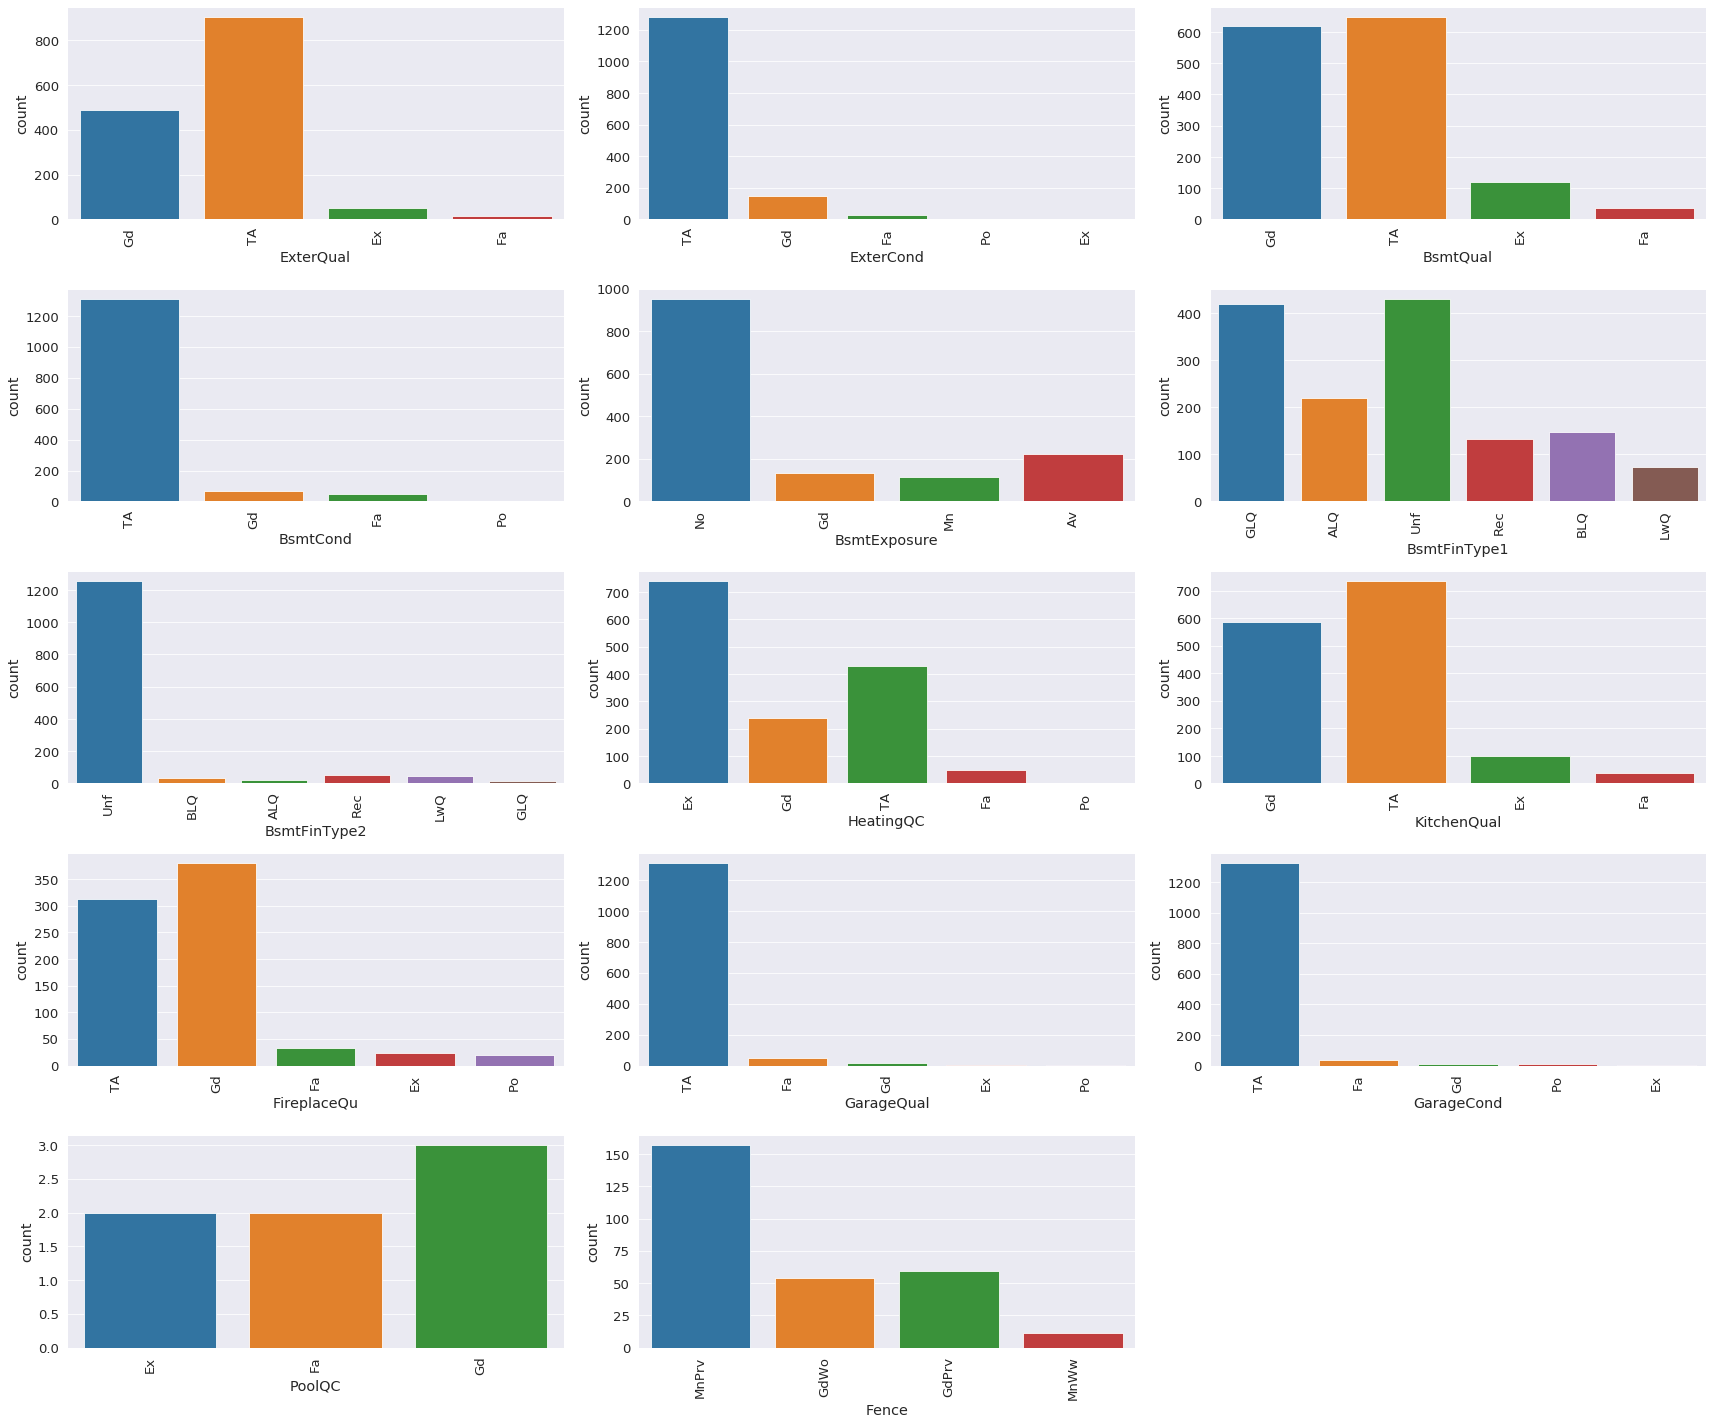

In [14]:
## Categorical : ordinal variables에 대해 분포를 확인해 보겠습니다.

sns.set_context('paper',font_scale=1.5)
fig = plt.figure(figsize=(24,20))

for index,col in enumerate(ordinal):
    plt.subplot(5,3,index+1)
    sns.countplot(x=col, data=train[ordinal])
    plt.xticks(rotation=90)
fig.tight_layout(pad=1.0)

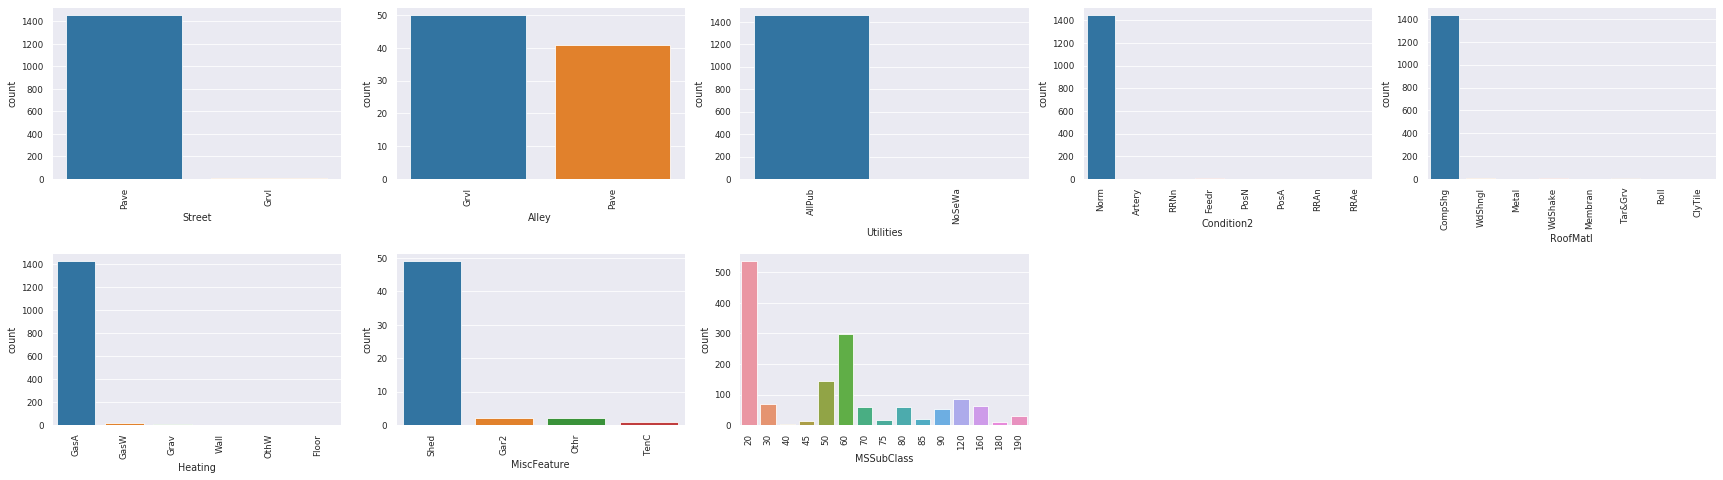

In [15]:
## Categorical : nominal variables 의 분포를 확인해 보겠습니다.

sns.set_context('paper',font_scale=1)
fig = plt.figure(figsize=(24,30))

for index,col in enumerate(nominal):
    plt.subplot(9,5,index+1)
    sns.countplot(x=col, data=train[nominal])
    plt.xticks(rotation=90)
fig.tight_layout(pad=1.0)

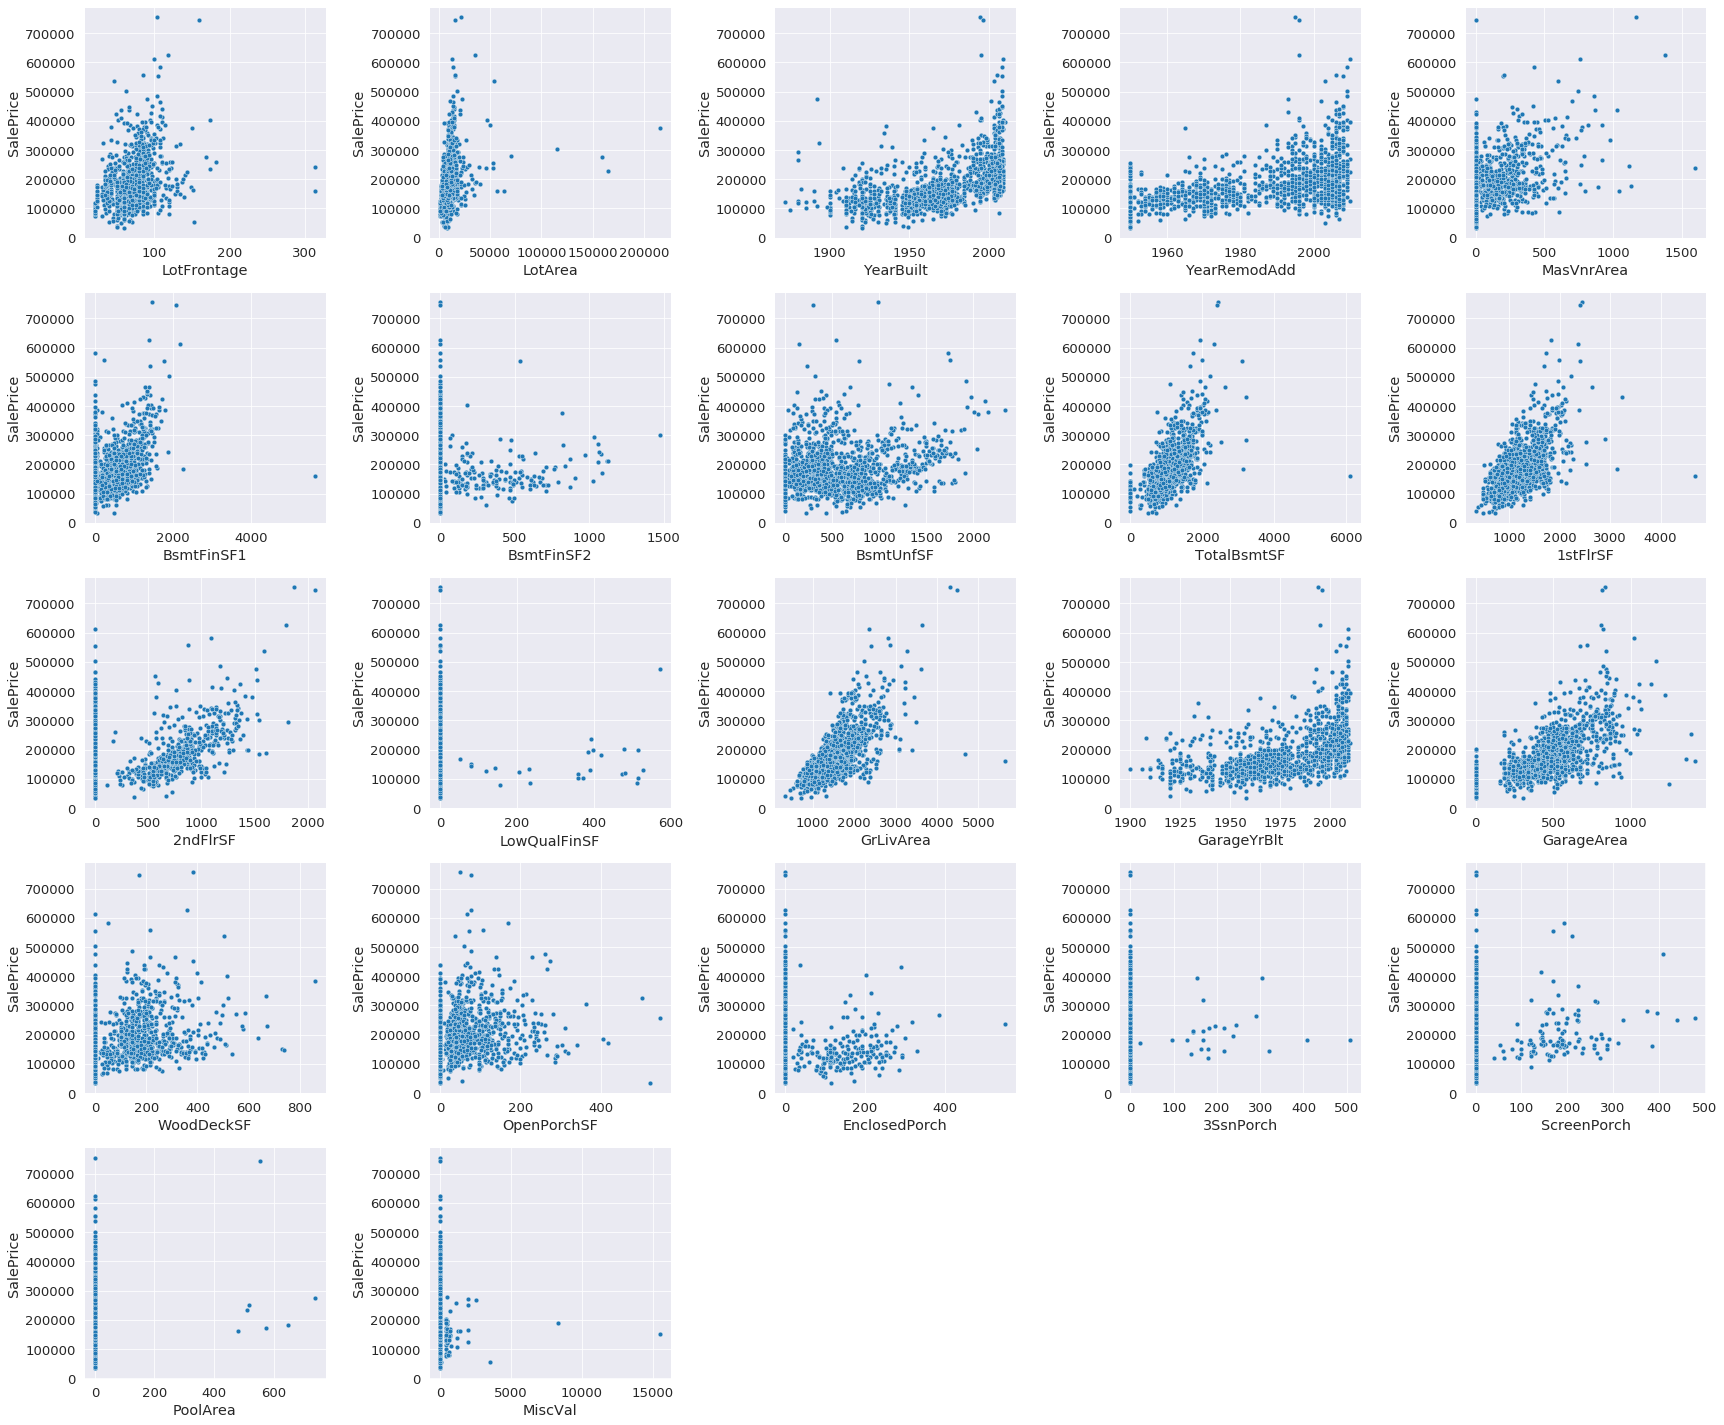

In [16]:
# Numerical : continuious columns - Target(SalePrice) // feature와 target의 관계를 보도록 하겠습니다.

sns.set_context('paper',font_scale=1.5)
fig = plt.figure(figsize=(24,20))

for index in range(len(continuous)):
    plt.subplot(5,5,index+1)
    sns.scatterplot(x=train[continuous].iloc[:,index],
                    y=train['SalePrice'],
                    data=train)
fig.tight_layout(pad=1.0)

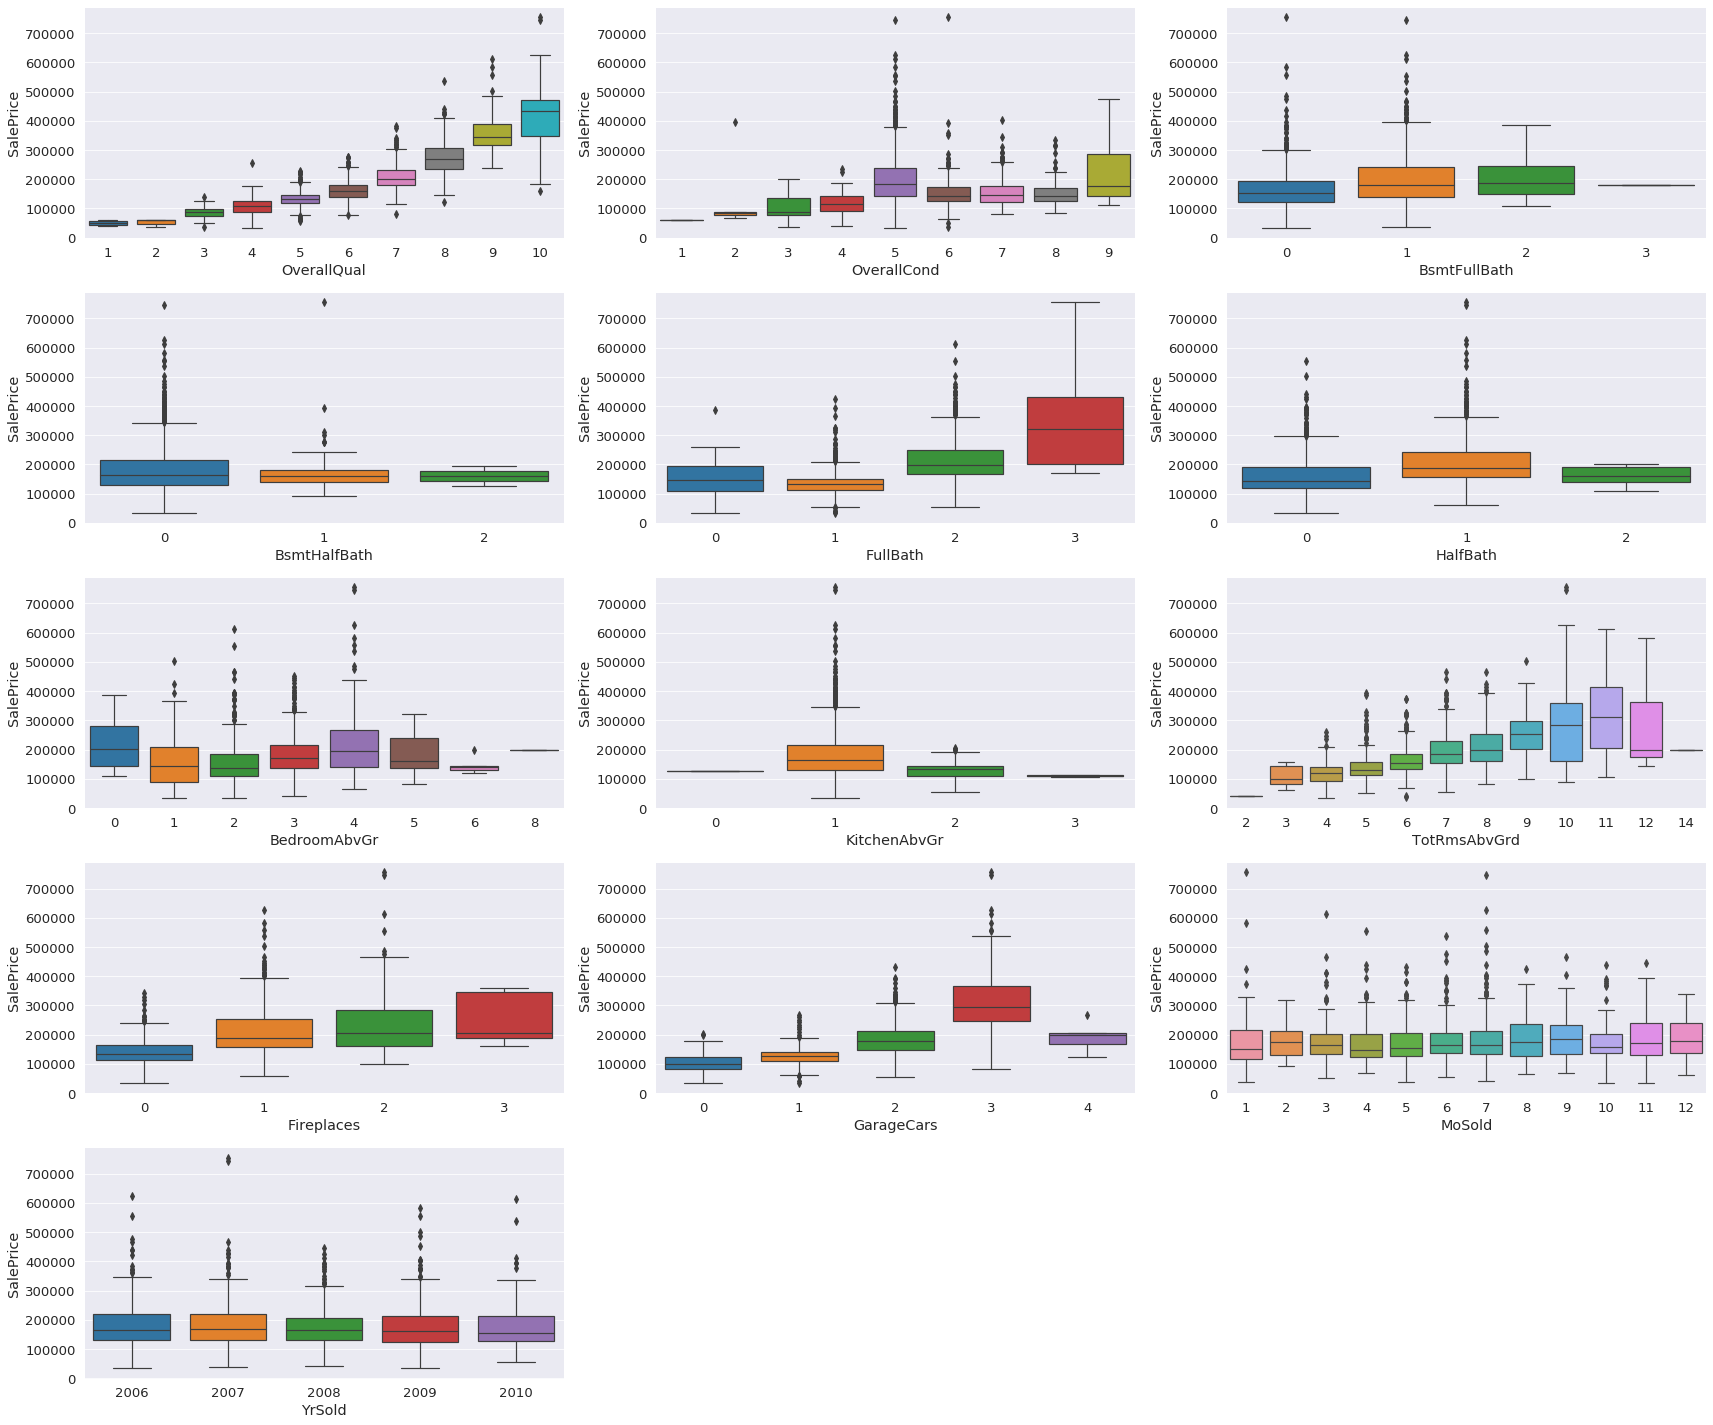

In [17]:
# Numerical : discrete columns - Target(SalePrice) // feature와 target의 관계를 보도록 하겠습니다.


discrete_SalePrice = discrete + ['SalePrice']

sns.set_context('paper',font_scale=1.5)
fig = plt.figure(figsize=(24,20))

for index,col in enumerate(discrete):
    plt.subplot(5,3,index+1)
    sns.boxplot(x=col,y='SalePrice',data=train[discrete_SalePrice])
    #plt.xticks(rotation=90)
fig.tight_layout(pad=1.0)

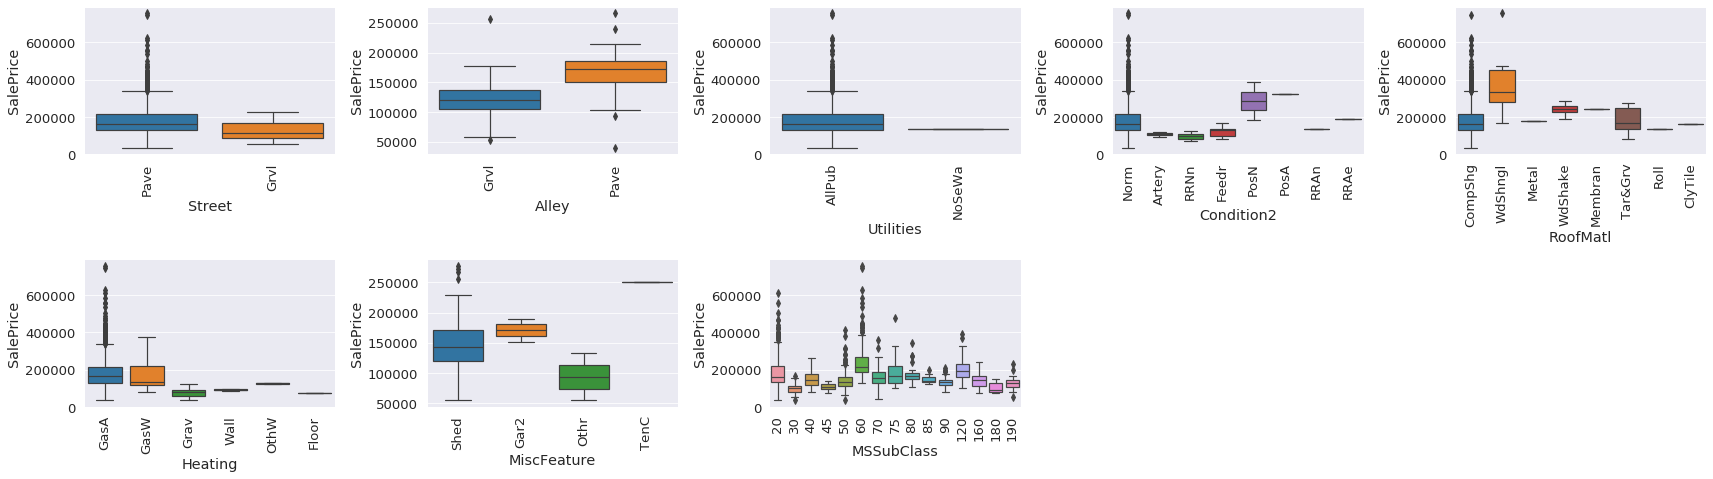

In [18]:
# Categorical : nominal columns - Target(SalePrice) // feature와 target의 관계를 보도록 하겠습니다.

nominal_SalePrice = nominal + ['SalePrice']

sns.set_context('paper',font_scale=1.5)
fig = plt.figure(figsize=(24,20))

for index,col in enumerate(nominal):
    plt.subplot(6,5,index+1)
    sns.boxplot(x=col,y='SalePrice',data=train[nominal_SalePrice])
    plt.xticks(rotation=90)
fig.tight_layout(pad=1.0)



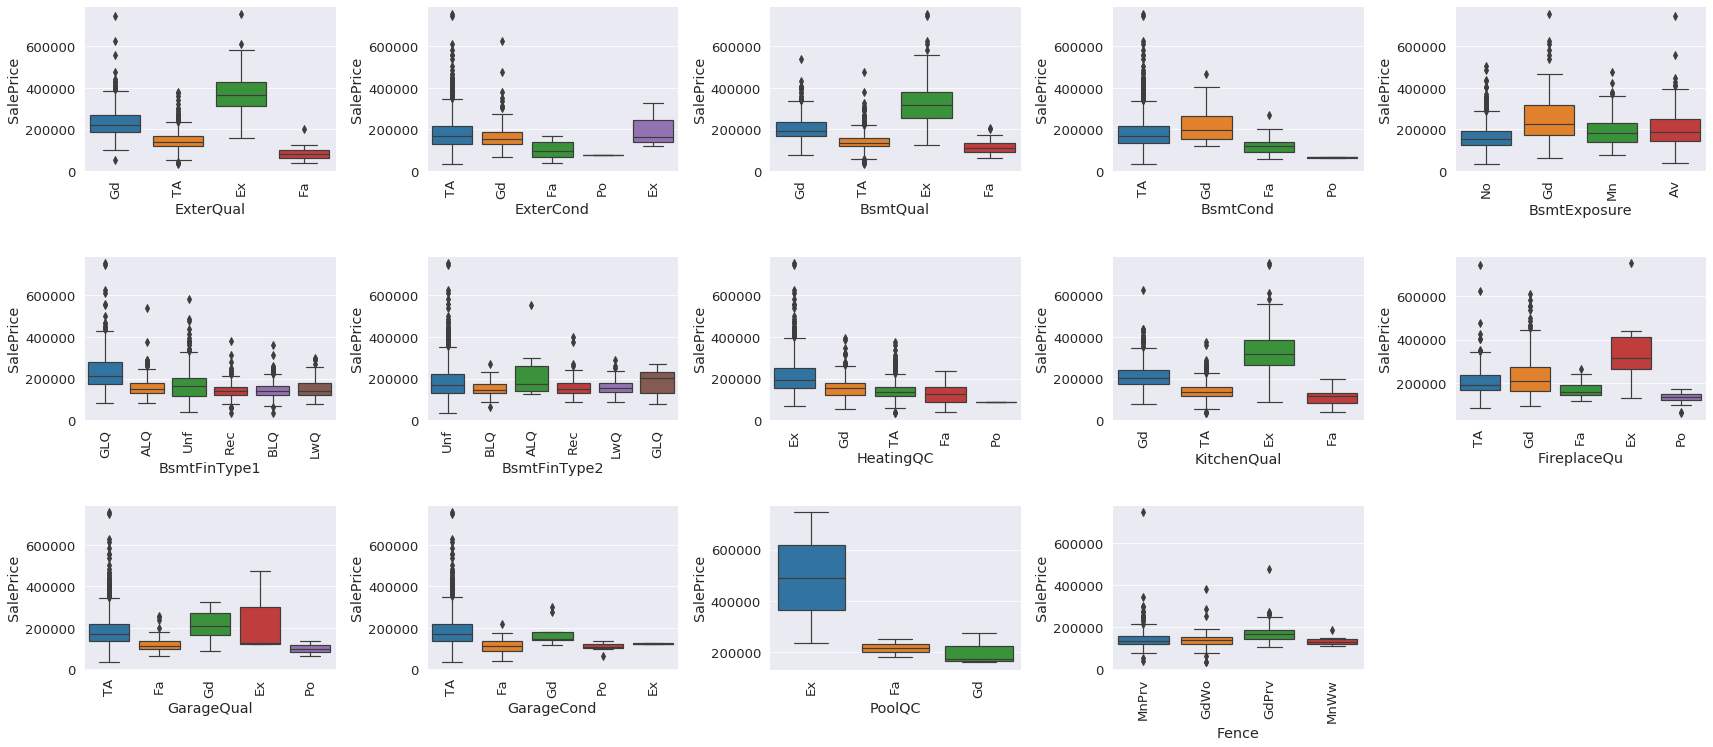

In [19]:
# Categorical : ordinal columns - Target(SalePrice) // feature와 target의 관계를 보도록 하겠습니다.

ordinal_SalePrice = ordinal + ['SalePrice']

sns.set_context('paper',font_scale=1.5)
fig = plt.figure(figsize=(24,20))

for index,col in enumerate(ordinal):
    plt.subplot(6,5,index+1)
    sns.boxplot(x=col,y='SalePrice',data=train[ordinal_SalePrice])
    plt.xticks(rotation=90)
fig.tight_layout(pad=1.0)

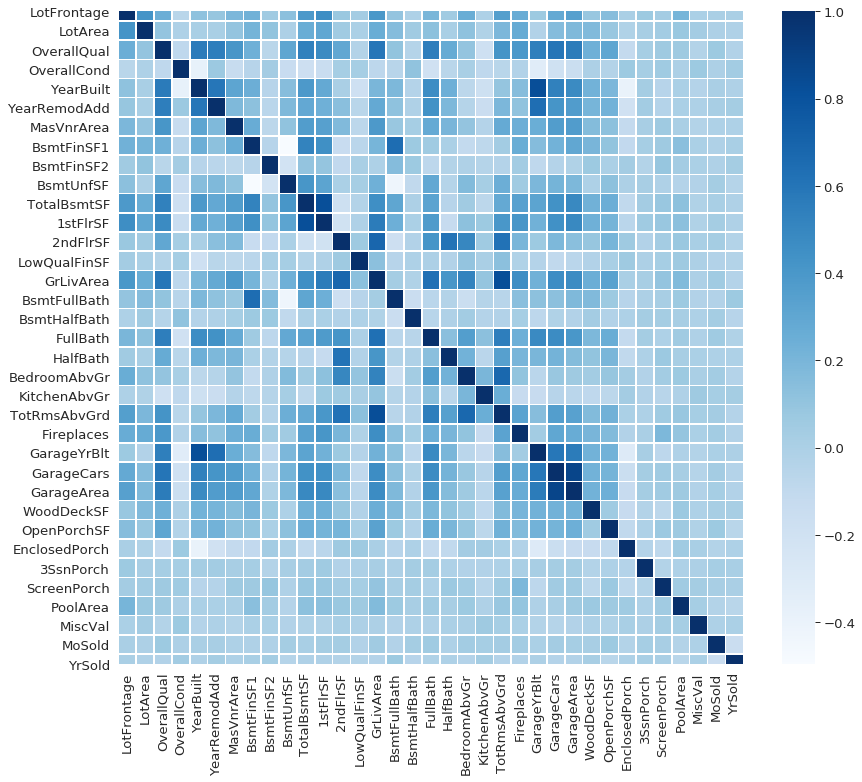

In [20]:
## 각 feature 별 correlation 확인 (다중공선성 확인)

plt.figure(figsize=(14,12))
numeric_correlation = train[numeric_cols].corr()
sns.set_style('darkgrid')
sns.heatmap(numeric_correlation, 
            #mask = num_correlation < 0.8,
            linewidth=0.5,
            cmap='Blues');

In [21]:
## correlation이 0.8이상인 feature 출력 (다중공선성 확인)

t1 = numeric_correlation.abs().unstack().drop_duplicates().sort_values(ascending=False)
t1[(t1< 1) & (t1 >= 0.8)]

GarageCars   GarageArea      0.882475
YearBuilt    GarageYrBlt     0.825667
GrLivArea    TotRmsAbvGrd    0.825489
TotalBsmtSF  1stFlrSF        0.819530
dtype: float64

In [22]:
## numeric feature와 target과의 correlation

numeric_cols_SalePrice = numeric_cols + ['SalePrice']
correlation = train[numeric_cols_SalePrice].corr()
c1 = correlation[['SalePrice']].sort_values(['SalePrice'],ascending=False)
c1[1:10]

,SalePrice
OverallQual,0.790982
GrLivArea,0.708624
GarageCars,0.640409
GarageArea,0.623431
TotalBsmtSF,0.613581
1stFlrSF,0.605852
FullBath,0.560664
TotRmsAbvGrd,0.533723
YearBuilt,0.522897


In [ ]:
## 위에서 확인한 바와 같이 "feature간의 상관관계가 높은 것" 들은 아래에서 정리 하도록 하겠습니다.

In [23]:
train = pd.read_csv('/content/train.csv',index_col=0)
test = pd.read_csv('/content/test.csv',index_col=0)

train.drop(['MSZoning', 'LandContour', 'LotShape', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'BldgType', 'HouseStyle', 'RoofStyle', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Foundation', 'CentralAir', 'Electrical', 'Functional', 'GarageType', 'GarageFinish', 'PavedDrive', 'SaleType', 'SaleCondition'],axis=1,inplace=True)
test.drop(['MSZoning', 'LandContour', 'LotShape', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'BldgType', 'HouseStyle', 'RoofStyle', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Foundation', 'CentralAir', 'Electrical', 'Functional', 'GarageType', 'GarageFinish', 'PavedDrive', 'SaleType', 'SaleCondition'],axis=1,inplace=True)

merge_traintest = pd.concat([train,test], axis = 0)

In [24]:
print(f'train dataset:{train.shape}')
print(f'test dataset:{test.shape}')
print(f'merge_traintest dataset:{merge_traintest.shape}')

train dataset:(1460, 58)
test dataset:(1459, 57)
merge_traintest dataset:(2919, 58)


In [25]:
def missing_value(df):
    number = df.isnull().sum().sort_values(ascending=False)
    number = number[number > 0]
    percentage = df.isnull().sum() *100 / df.shape[0]
    percentage = percentage[percentage > 0].sort_values(ascending=False)
    return  pd.concat([number,percentage],keys=["Total","Percentage"],axis=1)

    

In [26]:
missing_value(merge_traintest)

,Total,Percentage
PoolQC,2909,99.657417
MiscFeature,2814,96.402878
Alley,2721,93.216855
Fence,2348,80.438506
SalePrice,1459,49.982871
FireplaceQu,1420,48.646797
LotFrontage,486,16.649538
GarageCond,159,5.447071
GarageQual,159,5.447071
GarageYrBlt,159,5.447071


In [27]:
## 결측치의 비율이 90%넘으므로 해당 feature를 제거하겠습니다. ordinal encoding을 해도 NaN의 비율이 너무 높기때문.

merge_traintest.drop(['PoolQC','MiscFeature','Alley'],axis=1,inplace=True)


In [28]:
merge_traintest.shape

(2919, 55)

In [29]:
ordinal.remove('PoolQC')

nominal.remove('MiscFeature')
nominal.remove('Alley')

In [30]:
## Multicolinearity - numerical features

# GarageCars   GarageArea      0.882475
# YearBuilt    GarageYrBlt     0.825667
# GrLivArea    TotRmsAbvGrd    0.825489
# TotalBsmtSF  1stFlrSF        0.819530

merge_traintest.drop(['GarageCars','GarageYrBlt','TotRmsAbvGrd','1stFlrSF'], axis=1, inplace=True)


In [31]:
discrete.remove('TotRmsAbvGrd')
discrete.remove('GarageCars')

continuous.remove('1stFlrSF')
continuous.remove('GarageYrBlt')

In [32]:
merge_traintest.shape

(2919, 51)

In [33]:
import statistics as sts
%matplotlib inline

In [34]:
missing_value(merge_traintest[continuous])

,Total,Percentage
LotFrontage,486,16.649538
MasVnrArea,23,0.787941
TotalBsmtSF,1,0.034258
BsmtFinSF1,1,0.034258
GarageArea,1,0.034258
BsmtFinSF2,1,0.034258
BsmtUnfSF,1,0.034258


In [35]:
## Missing values - continuous features

# LotFrontage - missing values imputed using median of Neighborhood
merge_traintest['LotFrontage'] = merge_traintest['LotFrontage'].transform(lambda x: x.fillna(x.median()))
# MasVnrArea - missing values imputed using mode
merge_traintest['MasVnrArea'] = merge_traintest['MasVnrArea'].fillna(sts.mode(merge_traintest['MasVnrArea']))
# GarageArea - missing values imputed using mean value
merge_traintest['GarageArea'] = merge_traintest['GarageArea'].fillna(merge_traintest['GarageArea'].mean())
# BsmtFinSF1 - missing values imputed using mode value
merge_traintest['BsmtFinSF1'] = merge_traintest['BsmtFinSF1'].fillna(sts.mode(merge_traintest['BsmtFinSF1']))
# BsmtFinSF2 - missing values imputed using mode value
merge_traintest['BsmtFinSF2'] = merge_traintest['BsmtFinSF2'].fillna(sts.mode(merge_traintest['BsmtFinSF2']))
# BsmtUnfSF - missing values imputed using median value
merge_traintest['BsmtUnfSF'] = merge_traintest['BsmtUnfSF'].fillna(merge_traintest['BsmtUnfSF'].median())
# TotalBsmtSF - missing values imputed using mean value
merge_traintest['TotalBsmtSF'] = merge_traintest['TotalBsmtSF'].fillna(merge_traintest['TotalBsmtSF'].mean())

In [36]:
missing_value(merge_traintest[discrete])

,Total,Percentage
BsmtHalfBath,2,0.068517
BsmtFullBath,2,0.068517


In [37]:
# BsmtFullBath - missing values imputed using mode value
merge_traintest['BsmtFullBath'] = merge_traintest['BsmtFullBath'].fillna(sts.mode(merge_traintest['BsmtFullBath']))
# BsmtFullBath - missing values imputed using mode value
merge_traintest['BsmtHalfBath'] = merge_traintest['BsmtHalfBath'].fillna(sts.mode(merge_traintest['BsmtHalfBath']))

In [38]:
missing_value(merge_traintest[nominal])

,Total,Percentage
Utilities,2,0.068517


In [39]:
missing_nominal = list(missing_value(merge_traintest[nominal]).index)
merge_traintest[missing_nominal] = merge_traintest[missing_nominal].transform(lambda x : x.fillna(x.mode()[0]))

In [40]:
missing_value(merge_traintest[ordinal])

,Total,Percentage
Fence,2348,80.438506
FireplaceQu,1420,48.646797
GarageCond,159,5.447071
GarageQual,159,5.447071
BsmtExposure,82,2.809181
BsmtCond,82,2.809181
BsmtQual,81,2.774923
BsmtFinType2,80,2.740665
BsmtFinType1,79,2.706406
KitchenQual,1,0.034258


In [41]:
missing_ordinal = list(missing_value(merge_traintest[ordinal]).index)
merge_traintest[missing_ordinal] = merge_traintest[missing_ordinal].fillna("NA")

In [42]:
single_ordinal = []
for i in ordinal:
    counts = train[i].value_counts()
    zeros = counts.iloc[0]
    if zeros / len(train) * 100 > 90:
        single_ordinal.append(i)

single_ordinal = list(single_ordinal)

In [43]:
single_ordinal

['GarageCond']

In [44]:
pd.DataFrame({'count': train['GarageCond'].dropna().value_counts(), 
                  '%': train['GarageCond'].dropna().value_counts()/len(train)*100})

,count,%
TA,1326,90.821918
Fa,35,2.397260
Gd,9,0.616438
Po,7,0.479452
Ex,2,0.136986


In [45]:
train['GarageCond'].isnull().sum()

81

In [46]:
# Dropping GarageCond as 90% of its non NA values are in a single class

merge_traintest.drop('GarageCond', axis=1, inplace=True)

In [47]:
merge_traintest.shape

(2919, 50)

In [48]:
ordinal.remove('GarageCond')

In [49]:
single_nominal = []
for i in nominal:
    counts = train[i].value_counts()
    zeros = counts.iloc[0]
    if zeros / len(train) * 100 > 95:
        single_nominal.append(i)

single_nominal = list(single_nominal)

In [51]:
single_nominal

['Street', 'Utilities', 'Condition2', 'RoofMatl', 'Heating']

In [52]:
pd.DataFrame({'count': train['Street'].value_counts(), 
                  '%': train['Street'].value_counts()/len(train)*100})

,count,%
Pave,1454,99.589041
Grvl,6,0.410959


In [53]:
pd.DataFrame({'count': train['Utilities'].value_counts(), 
                  '%': train['Utilities'].value_counts()/len(train)*100})

,count,%
AllPub,1459,99.931507
NoSeWa,1,0.068493


In [54]:
pd.DataFrame({'count': train['Condition2'].value_counts(), 
                  '%': train['Condition2'].value_counts()/len(train)*100})

,count,%
Norm,1445,98.972603
Feedr,6,0.410959
RRNn,2,0.136986
Artery,2,0.136986
PosN,2,0.136986
RRAn,1,0.068493
PosA,1,0.068493
RRAe,1,0.068493


In [55]:
pd.DataFrame({'count': train['RoofMatl'].value_counts(), 
                  '%': train['RoofMatl'].value_counts()/len(train)*100})


,count,%
CompShg,1434,98.219178
Tar&Grv,11,0.753425
WdShngl,6,0.410959
WdShake,5,0.342466
ClyTile,1,0.068493
Membran,1,0.068493
Roll,1,0.068493
Metal,1,0.068493


In [56]:
pd.DataFrame({'count': train['Heating'].value_counts(), 
                  '%': train['Heating'].value_counts()/len(train)*100})

,count,%
GasA,1428,97.808219
GasW,18,1.232877
Grav,7,0.479452
Wall,4,0.273973
OthW,2,0.136986
Floor,1,0.068493


In [57]:
merge_traintest.drop(single_nominal,axis=1,inplace=True)

In [58]:
merge_traintest.shape

(2919, 45)

In [59]:
nominal.remove('Street')
nominal.remove('Utilities')
nominal.remove('Condition2')
nominal.remove('RoofMatl')
nominal.remove('Heating')

# Target outliers 제거



In [60]:
merge_traintest['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

In [61]:
merge_traintest.isnull().sum()

MSSubClass          0
LotFrontage         0
LotArea             0
OverallQual         0
OverallCond         0
YearBuilt           0
YearRemodAdd        0
MasVnrArea          0
ExterQual           0
ExterCond           0
BsmtQual            0
BsmtCond            0
BsmtExposure        0
BsmtFinType1        0
BsmtFinSF1          0
BsmtFinType2        0
BsmtFinSF2          0
BsmtUnfSF           0
TotalBsmtSF         0
HeatingQC           0
2ndFlrSF            0
LowQualFinSF        0
GrLivArea           0
BsmtFullBath        0
BsmtHalfBath        0
FullBath            0
HalfBath            0
BedroomAbvGr        0
KitchenAbvGr        0
KitchenQual         0
Fireplaces          0
FireplaceQu         0
GarageArea          0
GarageQual          0
WoodDeckSF          0
OpenPorchSF         0
EnclosedPorch       0
3SsnPorch           0
ScreenPorch         0
PoolArea            0
Fence               0
MiscVal             0
MoSold              0
YrSold              0
SalePrice        1459
dtype: int

In [62]:
merge_traintest[merge_traintest['SalePrice'] > 500000]

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,Fireplaces,FireplaceQu,GarageArea,GarageQual,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,Fence,MiscVal,MoSold,YrSold,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
179,20,63.0,17423,9,5,2008,2009,748.0,Ex,TA,Ex,TA,No,GLQ,1904.0,Unf,0.0,312.0,2216.0,Ex,0,0,2234,1.0,0.0,2,0,1,1,Ex,1,Gd,1166.0,TA,0,60,0,0,0,0,NA,0,7,2009,501837.0
441,20,105.0,15431,10,5,2008,2008,200.0,Ex,TA,Ex,TA,Gd,GLQ,1767.0,ALQ,539.0,788.0,3094.0,Ex,0,0,2402,1.0,0.0,2,0,2,1,Ex,2,Gd,672.0,TA,0,72,0,0,170,0,NA,0,4,2009,555000.0
692,60,104.0,21535,10,6,1994,1995,1170.0,Ex,TA,Ex,TA,Gd,GLQ,1455.0,Unf,0.0,989.0,2444.0,Ex,1872,0,4316,0.0,1.0,3,1,4,1,Ex,2,Ex,832.0,TA,382,50,0,0,0,0,NA,0,1,2007,755000.0
770,60,47.0,53504,8,5,2003,2003,603.0,Ex,TA,Gd,TA,Gd,ALQ,1416.0,Unf,0.0,234.0,1650.0,Ex,1589,0,3279,1.0,0.0,3,1,4,1,Ex,1,Gd,841.0,TA,503,36,0,0,210,0,NA,0,6,2010,538000.0
804,60,107.0,13891,9,5,2008,2009,424.0,Ex,TA,Ex,TA,Gd,Unf,0.0,Unf,0.0,1734.0,1734.0,Ex,1088,0,2822,0.0,0.0,3,1,4,1,Ex,1,Gd,1020.0,TA,52,170,0,0,192,0,NA,0,1,2009,582933.0
899,20,100.0,12919,9,5,2009,2010,760.0,Ex,TA,Ex,TA,Gd,GLQ,2188.0,Unf,0.0,142.0,2330.0,Ex,0,0,2364,1.0,0.0,2,1,2,1,Ex,2,Gd,820.0,TA,0,67,0,0,0,0,NA,0,3,2010,611657.0
1047,60,85.0,16056,9,5,2005,2006,208.0,Gd,TA,Ex,TA,Av,GLQ,240.0,Unf,0.0,1752.0,1992.0,Ex,876,0,2868,0.0,0.0,3,1,4,1,Ex,1,Gd,716.0,TA,214,108,0,0,0,0,NA,0,7,2006,556581.0
1170,60,118.0,35760,10,5,1995,1996,1378.0,Gd,Gd,Ex,TA,Gd,GLQ,1387.0,Unf,0.0,543.0,1930.0,Ex,1796,0,3627,1.0,0.0,3,1,4,1,Gd,1,TA,807.0,TA,361,76,0,0,0,0,NA,0,7,2006,625000.0
1183,60,160.0,15623,10,5,1996,1996,0.0,Gd,TA,Ex,TA,Av,GLQ,2096.0,Unf,0.0,300.0,2396.0,Ex,2065,0,4476,1.0,0.0,3,1,4,1,Ex,2,TA,813.0,TA,171,78,0,0,0,555,MnPrv,0,7,2007,745000.0


In [63]:
merge_traintest = merge_traintest.drop(merge_traintest[merge_traintest['SalePrice']>500000].index)

In [64]:
merge_traintest['SalePrice'] = np.log(merge_traintest['SalePrice'])

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


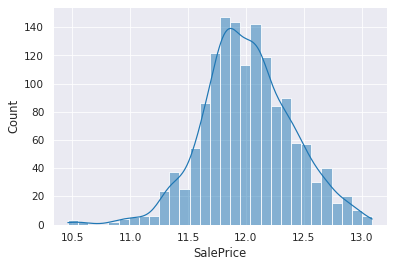

In [65]:
sns.set_context('paper',font_scale=1.2)
sns.set_style('darkgrid')
sns.histplot(x='SalePrice', data = merge_traintest,bins=30,kde=True)
plt.show()

In [66]:
merge_traintest['SalePrice'].describe()

count    1451.000000
mean       12.016082
std         0.387473
min        10.460242
25%        11.774520
50%        11.998433
75%        12.269047
max        13.091904
Name: SalePrice, dtype: float64

# ML - @@@@@@@@

In [67]:
## 데이터 전처리를 위해 merge한 data를 target수치 기준으로 나눠주겠습니다.

X = merge_traintest.iloc[:1451,]
y = X['SalePrice']
test = merge_traintest.iloc[1451:,]

X.drop('SalePrice',axis=1,inplace=True)
test.drop('SalePrice',axis=1,inplace=True)


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [68]:
X.shape, test.shape

((1451, 44), (1459, 44))

In [69]:
X.columns

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'ExterQual', 'ExterCond',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'HeatingQC',
       '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath',
       'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'Fireplaces', 'FireplaceQu', 'GarageArea', 'GarageQual', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'Fence', 'MiscVal', 'MoSold', 'YrSold'],
      dtype='object')

In [70]:
Baseline_before1 ## SalePrice > 500000 data 제거 전_log_평균 가격

12.024050901109373

In [71]:
y.mean() ## SalePrice > 500000 data 제거 후_log_평균 가격

12.016082361002281

In [72]:
X

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,Fireplaces,FireplaceQu,GarageArea,GarageQual,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,Fence,MiscVal,MoSold,YrSold
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,60,65.0,8450,7,5,2003,2003,196.0,Gd,TA,Gd,TA,No,GLQ,706.0,Unf,0.0,150.0,856.0,Ex,854,0,1710,1.0,0.0,2,1,3,1,Gd,0,NA,548.0,TA,0,61,0,0,0,0,NA,0,2,2008
2,20,80.0,9600,6,8,1976,1976,0.0,TA,TA,Gd,TA,Gd,ALQ,978.0,Unf,0.0,284.0,1262.0,Ex,0,0,1262,0.0,1.0,2,0,3,1,TA,1,TA,460.0,TA,298,0,0,0,0,0,NA,0,5,2007
3,60,68.0,11250,7,5,2001,2002,162.0,Gd,TA,Gd,TA,Mn,GLQ,486.0,Unf,0.0,434.0,920.0,Ex,866,0,1786,1.0,0.0,2,1,3,1,Gd,1,TA,608.0,TA,0,42,0,0,0,0,NA,0,9,2008
4,70,60.0,9550,7,5,1915,1970,0.0,TA,TA,TA,Gd,No,ALQ,216.0,Unf,0.0,540.0,756.0,Gd,756,0,1717,1.0,0.0,1,0,3,1,Gd,1,Gd,642.0,TA,0,35,272,0,0,0,NA,0,2,2006
5,60,84.0,14260,8,5,2000,2000,350.0,Gd,TA,Gd,TA,Av,GLQ,655.0,Unf,0.0,490.0,1145.0,Ex,1053,0,2198,1.0,0.0,2,1,4,1,Gd,1,TA,836.0,TA,192,84,0,0,0,0,NA,0,12,2008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,60,62.0,7917,6,5,1999,2000,0.0,TA,TA,Gd,TA,No,Unf,0.0,Unf,0.0,953.0,953.0,Ex,694,0,1647,0.0,0.0,2,1,3,1,TA,1,TA,460.0,TA,0,40,0,0,0,0,NA,0,8,2007
1457,20,85.0,13175,6,6,1978,1988,119.0,TA,TA,Gd,TA,No,ALQ,790.0,Rec,163.0,589.0,1542.0,TA,0,0,2073,1.0,0.0,2,0,3,1,TA,2,TA,500.0,TA,349,0,0,0,0,0,MnPrv,0,2,2010
1458,70,66.0,9042,7,9,1941,2006,0.0,Ex,Gd,TA,Gd,No,GLQ,275.0,Unf,0.0,877.0,1152.0,Ex,1152,0,2340,0.0,0.0,2,0,4,1,Gd,2,Gd,252.0,TA,0,60,0,0,0,0,GdPrv,2500,5,2010


# Scaling the data

In [73]:
from sklearn.preprocessing import RobustScaler

cols = X.select_dtypes(np.number).columns
transformer = RobustScaler().fit(X[cols])

X[cols] = transformer.transform(X[cols])
test[cols] = transformer.transform(test[cols])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: 

In [74]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=21)

In [75]:
X_train.shape

(1160, 44)

In [76]:
X_val.shape

(291, 44)

In [77]:
y_train.shape

(1160,)

In [78]:
y_val.shape

(291,)

In [79]:
X_train.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,Fireplaces,FireplaceQu,GarageArea,GarageQual,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,Fence,MiscVal,MoSold,YrSold
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1285,0.0,-0.972973,0.046634,0.0,2.0,-1.152174,-0.078947,0.0,TA,TA,TA,TA,No,Unf,-0.540043,Unf,0.0,0.559727,-0.379205,Ex,1.027473,0.0,1.544817,0.0,0.0,0.0,0.0,1.0,0.0,Gd,0.0,Gd,-0.571429,TA,1.619048,-0.352941,42.0,0.0,116.0,0.0,NA,0.0,-1.000000,1.0
1415,0.0,-0.216216,0.902846,0.0,2.0,-1.065217,0.184211,0.0,TA,TA,TA,TA,No,Unf,-0.540043,Unf,0.0,0.609215,-0.320082,Gd,1.092033,0.0,0.611068,0.0,0.0,-1.0,1.0,1.0,0.0,Gd,0.0,Gd,-0.434608,TA,0.000000,-0.352941,0.0,0.0,220.0,0.0,NA,0.0,0.000000,0.0
93,-0.4,0.648649,0.979817,-0.5,2.0,-1.108696,0.342105,0.0,TA,Gd,Gd,TA,No,ALQ,0.470588,Unf,0.0,-0.534130,-0.232416,Ex,0.000000,0.0,-0.766952,1.0,0.0,-1.0,0.0,-1.0,0.0,TA,-1.0,NA,-0.185111,TA,0.000000,-0.352941,44.0,0.0,0.0,0.0,NA,0.0,0.666667,0.5
941,0.8,-0.702703,0.799298,0.0,0.0,0.086957,-0.447368,0.0,TA,TA,TA,TA,Gd,Rec,0.786676,LwQ,396.0,-0.136519,1.504587,TA,0.000000,0.0,0.424006,0.0,0.0,0.0,0.0,1.0,1.0,TA,-1.0,NA,0.386318,TA,0.238095,-0.352941,0.0,0.0,0.0,0.0,NA,0.0,0.333333,-1.0
190,1.4,-1.459459,-1.135515,1.0,0.0,0.630435,0.236842,0.0,Gd,TA,Ex,TA,Av,GLQ,1.094259,Unf,0.0,-0.061433,1.229358,Ex,0.000000,0.0,0.213562,1.0,0.0,-1.0,1.0,-3.0,0.0,Ex,0.0,Gd,0.820926,TA,0.000000,1.411765,0.0,0.0,224.0,0.0,NA,0.0,0.666667,0.0


In [80]:
test.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,Fireplaces,FireplaceQu,GarageArea,GarageQual,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,Fence,MiscVal,MoSold,YrSold
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1461,-0.6,0.648649,0.544064,-0.5,1.0,-0.239130,-0.842105,0.000000,TA,TA,TA,TA,No,Rec,0.123317,LwQ,144.0,-0.351536,-0.220183,TA,0.000000,0.0,-0.872954,0.0,0.0,-1.0,0.0,-1.0,0.0,TA,-1.0,NA,1.014085,TA,0.833333,-0.352941,0.0,0.0,120.0,0.0,MnPrv,0.0,0.000000,1.0
1462,-0.6,0.702703,1.207221,0.0,1.0,-0.304348,-0.921053,0.672897,TA,TA,TA,TA,No,ALQ,0.768249,Unf,0.0,-0.119454,0.691131,TA,0.000000,0.0,-0.197973,0.0,0.0,-1.0,1.0,0.0,0.0,Gd,-1.0,NA,-0.668008,TA,2.339286,0.176471,0.0,0.0,0.0,0.0,NA,12500.0,0.000000,1.0
1463,0.2,0.324324,1.097656,-0.5,0.0,0.543478,0.131579,0.000000,TA,TA,Gd,TA,No,GLQ,0.581148,Unf,0.0,-0.578498,-0.126402,Gd,0.962912,0.0,0.269680,0.0,0.0,0.0,1.0,0.0,0.0,TA,0.0,TA,0.016097,TA,1.261905,0.147059,0.0,0.0,0.0,0.0,MnPrv,0.0,-1.000000,1.0
1464,0.2,0.540541,0.131879,0.0,1.0,0.565217,0.131579,0.124611,TA,TA,TA,TA,No,GLQ,0.313253,Unf,0.0,-0.259386,-0.130479,Ex,0.931319,0.0,0.230709,0.0,0.0,0.0,1.0,0.0,0.0,Gd,0.0,Gd,-0.032193,TA,2.142857,0.176471,0.0,0.0,0.0,0.0,NA,0.0,0.000000,1.0
1465,1.4,-1.351351,-1.114955,1.0,0.0,0.434783,-0.026316,0.000000,Gd,TA,Gd,TA,No,ALQ,-0.167257,Unf,0.0,0.923208,0.591233,Ex,0.000000,0.0,-0.274357,0.0,0.0,0.0,0.0,-1.0,0.0,Gd,-1.0,NA,0.112676,TA,0.000000,0.852941,0.0,0.0,144.0,0.0,NA,0.0,-1.666667,1.0


In [81]:
X_train.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,Fireplaces,FireplaceQu,GarageArea,GarageQual,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,Fence,MiscVal,MoSold,YrSold
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1285,0.0,-0.972973,0.046634,0.0,2.0,-1.152174,-0.078947,0.0,TA,TA,TA,TA,No,Unf,-0.540043,Unf,0.0,0.559727,-0.379205,Ex,1.027473,0.0,1.544817,0.0,0.0,0.0,0.0,1.0,0.0,Gd,0.0,Gd,-0.571429,TA,1.619048,-0.352941,42.0,0.0,116.0,0.0,NA,0.0,-1.000000,1.0
1415,0.0,-0.216216,0.902846,0.0,2.0,-1.065217,0.184211,0.0,TA,TA,TA,TA,No,Unf,-0.540043,Unf,0.0,0.609215,-0.320082,Gd,1.092033,0.0,0.611068,0.0,0.0,-1.0,1.0,1.0,0.0,Gd,0.0,Gd,-0.434608,TA,0.000000,-0.352941,0.0,0.0,220.0,0.0,NA,0.0,0.000000,0.0
93,-0.4,0.648649,0.979817,-0.5,2.0,-1.108696,0.342105,0.0,TA,Gd,Gd,TA,No,ALQ,0.470588,Unf,0.0,-0.534130,-0.232416,Ex,0.000000,0.0,-0.766952,1.0,0.0,-1.0,0.0,-1.0,0.0,TA,-1.0,NA,-0.185111,TA,0.000000,-0.352941,44.0,0.0,0.0,0.0,NA,0.0,0.666667,0.5
941,0.8,-0.702703,0.799298,0.0,0.0,0.086957,-0.447368,0.0,TA,TA,TA,TA,Gd,Rec,0.786676,LwQ,396.0,-0.136519,1.504587,TA,0.000000,0.0,0.424006,0.0,0.0,0.0,0.0,1.0,1.0,TA,-1.0,NA,0.386318,TA,0.238095,-0.352941,0.0,0.0,0.0,0.0,NA,0.0,0.333333,-1.0
190,1.4,-1.459459,-1.135515,1.0,0.0,0.630435,0.236842,0.0,Gd,TA,Ex,TA,Av,GLQ,1.094259,Unf,0.0,-0.061433,1.229358,Ex,0.000000,0.0,0.213562,1.0,0.0,-1.0,1.0,-3.0,0.0,Ex,0.0,Gd,0.820926,TA,0.000000,1.411765,0.0,0.0,224.0,0.0,NA,0.0,0.666667,0.0


In [ ]:
## MsZoning, LotShape, LandConfig, LandSlope, Neighborhood, Condition1, Bldgtype, HouseStyle, RoofStyle, Exterior1st, Exterior2nd, MasVnrType, Foundation, CentralAir, Electrical, Functional, GarageType, GarageFinish, PavedDrive, SaleType, SaleCondition

In [82]:
enc_col = [
          {'col': 'GarageQual', 
           'mapping': {'Ex': 5,'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA':0}},
          {'col': 'FireplaceQu', 
           'mapping': {'Ex': 5,'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA':0}},
          {'col': 'KitchenQual', 
           'mapping': {'Ex': 5,'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA':0}},
          {'col': 'HeatingQC', 
           'mapping': {'Ex': 5,'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA':0}},
          {'col': 'BsmtCond', 
           'mapping': {'Ex': 5,'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA':0}},
          {'col': 'BsmtQual', 
           'mapping': {'Ex': 5,'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA':0}},
          {'col': 'ExterCond', 
           'mapping': {'Ex': 5,'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA':0}},
          {'col': 'ExterQual', 
           'mapping': {'Ex': 5,'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA':0}},
          {'col': 'BsmtFinType2', 
           'mapping': {'GLQ': 6,'ALQ': 5,'BLQ': 4,'Rec': 3,'LwQ': 2,'Unf': 1, 'NA': 0}},
          {'col': 'BsmtExposure',
           'mapping': {'Gd': 4, 'Av': 3, 'Mn': 2, 'No': 1, 'NA': 0}},
          {'col': 'BsmtFinType1',
           'mapping': {'GLQ': 6,'ALQ': 5,'BLQ': 4,'Rec': 3,'LwQ': 2,'Unf': 1, 'NA': 0}},
          {'col': 'Fence',
           'mapping': {'GdPrv': 4,'MnPrv': 3,'GdWo': 2, 'MnWw': 1,'NA': 0}}
          ]

In [ ]:
! pip install category_encoders

     |████████████████████████████████| 81kB 8.7MB/s 


In [88]:
from category_encoders import OrdinalEncoder, TargetEncoder, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score, accuracy_score

linear = make_pipeline(
    OrdinalEncoder(mapping=enc_col),
    LinearRegression()
)
linear.fit(X_train,y_train)
linear.predict(X_val)

print('score',linear.score(X_train, y_train))
print('R^2', r2_score(y_val,linear.predict(X_val)))

score 0.8653146982746135
R^2 0.8809002482784644


In [ ]:
print('MAE', mean_absolute_error(y_val, linear.predict(X_val)))

MAE 0.10239029696536749


In [ ]:
coefficients=linear.named_steps['linearregression'].coef_
pd.Series(coefficients, X_train.columns)

MSSubClass      -0.044503
LotFrontage     -0.010034
LotArea          0.009447
OverallQual      0.142897
OverallCond      0.046132
YearBuilt        0.098833
YearRemodAdd     0.023281
MasVnrArea      -0.000871
ExterQual        0.018212
ExterCond       -0.008193
BsmtQual         0.042754
BsmtCond         0.001568
BsmtExposure     0.011984
BsmtFinType1     0.010864
BsmtFinSF1      -0.011660
BsmtFinType2    -0.014766
BsmtFinSF2       0.000093
BsmtUnfSF       -0.002272
TotalBsmtSF     -0.019486
HeatingQC        0.016785
2ndFlrSF        -0.081982
LowQualFinSF    -0.000078
GrLivArea        0.169951
BsmtFullBath     0.043942
BsmtHalfBath     0.007463
FullBath         0.047440
HalfBath         0.044139
BedroomAbvGr     0.020200
KitchenAbvGr     0.018077
KitchenQual      0.021666
Fireplaces       0.005060
FireplaceQu      0.020241
GarageArea       0.042751
GarageQual       0.027360
WoodDeckSF       0.017566
OpenPorchSF     -0.007402
EnclosedPorch    0.000189
3SsnPorch        0.000146
ScreenPorch 

In [ ]:
from sklearn.tree import DecisionTreeRegressor

dctree = make_pipeline(
    OrdinalEncoder(mapping=enc_col),
    DecisionTreeRegressor()
)

dctree.fit(X_train, y_train)
dctree.predict(X_val)
print('MAE', mean_absolute_error(y_val, dctree.predict(X_val)))
print('R^2', r2_score(y_val, dctree.predict(X_val)))

MAE 0.14264234350281424
R^2 0.7428725395044342


In [93]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.feature_selection import f_regression, SelectKBest
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import randint, uniform

pipe1 = make_pipeline(
    OrdinalEncoder(mapping=enc_col),
    SelectKBest(f_regression),
    RandomForestRegressor(random_state=2)
)

dists = {
    'randomforestregressor__n_estimators': randint(50, 3000),
    'selectkbest__k': range(1, len(X_train.columns)+1), 
    'randomforestregressor__max_depth': randint(1,300), 
    'randomforestregressor__max_features': uniform(0, 1) # max_features
}

clf = RandomizedSearchCV(
    pipe1, 
    param_distributions=dists, 
    n_iter=50, 
    cv=6, 
    scoring='r2',  
    verbose=1,
    n_jobs=-1
)

clf.fit(X_train, y_train);

Fitting 6 folds for each of 50 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed: 18.0min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 25.9min finished


In [94]:
print('최적 하이퍼파라미터:', clf.best_params_)
print('R^2:', clf.best_score_)

최적 하이퍼파라미터: {'randomforestregressor__max_depth': 46, 'randomforestregressor__max_features': 0.39663848392455836, 'randomforestregressor__n_estimators': 588, 'selectkbest__k': 44}
R^2: 0.8680383379277529


In [ ]:
! pip install xgboost

In [ ]:
# pipeline = make_pipeline(XGBRegressor())
# sorted(pipeline.get_params().keys())

In [95]:
from xgboost import XGBRegressor

xgb = make_pipeline(
    OrdinalEncoder(mapping=enc_col),
    XGBRegressor()
)

dists = {
    'xgbregressor__learning_rate' : [0.01, 0.1, 0.15, 0.3, 0.5],
    'xgbregressor__n_estimators' : [100, 500, 1000, 2000, 3000],
    'xgbregressor__max_depth' : [3, 6, 9],
    'xgbregressor__min_child_weight' : [1, 5, 10, 20],
    'xgbregressor__reg_alpha' : [0.001, 0.01, 0.1],
    'xgbregressor__reg_lambda' : [0.001, 0.01, 0.1]
}

clf_xgb = RandomizedSearchCV(
    xgb, 
    param_distributions = dists, 
    n_iter=50, 
    cv=3, 
    scoring='r2',  
    verbose=1,
    n_jobs=-1
)

clf_xgb.fit(X_train, y_train);

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  3.2min finished


[05:37:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [96]:
print('최적 하이퍼파라미터:', clf_xgb.best_params_)
print('R^2:', clf_xgb.best_score_)

최적 하이퍼파라미터: {'xgbregressor__reg_lambda': 0.1, 'xgbregressor__reg_alpha': 0.01, 'xgbregressor__n_estimators': 3000, 'xgbregressor__min_child_weight': 1, 'xgbregressor__max_depth': 6, 'xgbregressor__learning_rate': 0.01}
R^2: 0.8778127388221683


In [97]:
clf_xgb_model = clf_xgb.best_estimator_

In [98]:
clf_xgb_model.predict

<function sklearn.pipeline.Pipeline.predict>

In [99]:
pred_test_xgb = clf_xgb.predict(test)

In [100]:
submission_xgb = np.exp(pred_test_xgb)
submission = pd.DataFrame({'Id': test.index,
                           'SalePrice': submission_xgb})

submission.to_csv("submission_xgb.csv", index=False)

## RMSE : 0.13962 (6191등 / 13457)
## test data 에 target 값이 없어 kaggle에 제출한 data를 바탕으로 점수를 적음

In [101]:
from sklearn.compose import TransformedTargetRegressor

In [104]:
tt = TransformedTargetRegressor(regressor=clf_xgb,
                                func=np.log1p, inverse_func=np.expm1)

tt.fit(X_train, y_train)
tt.accuracy(X_val, y_val)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   41.8s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.9min finished


[05:51:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


AttributeError: ignored

# PDP / SHAP 를 활용한 시각화

In [ ]:
from xgboost import XGBRegressor

encoder = OrdinalEncoder(mapping=enc_col)
X_train_encoded = encoder.fit_transform(X_train)
X_val_encoded = encoder.transform(X_val)

boosting = XGBRegressor(
    reg_lambda = 0.1,
    reg_alpha = 0.01,
    n_estimators = 2000,
    min_child_weight = 5,
    max_depth = 6,
    learning_rate = 0.01,
    n_jobs = -1,
    verbose=1
)

eval_set = [(X_train_encoded, y_train), 
            (X_val_encoded, y_val)]

boosting.fit(X_train_encoded, y_train, 
          eval_set=eval_set,
          early_stopping_rounds=50
         )


[01:43:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:11.401	validation_1-rmse:11.4333
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 50 rounds.
[1]	validation_0-rmse:11.2871	validation_1-rmse:11.3191
[2]	validation_0-rmse:11.1743	validation_1-rmse:11.2061
[3]	validation_0-rmse:11.0626	validation_1-rmse:11.0941
[4]	validation_0-rmse:10.9521	validation_1-rmse:10.9834
[5]	validation_0-rmse:10.8427	validation_1-rmse:10.8737
[6]	validation_0-rmse:10.7343	validation_1-rmse:10.7651
[7]	validation_0-rmse:10.6271	validation_1-rmse:10.6576
[8]	validation_0-rmse:10.5209	validation_1-rmse:10.5511
[9]	validation_0-rmse:10.4158	validation_1-rmse:10.4458
[10]	validation_0-rmse:10.3117	validation_1-rmse:10.3415
[11]	validation_0-rmse:10.2087	validation_1-rmse:10.2382
[12]	validation_0-rmse:10.1067	validation

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.01, max_delta_step=0,
             max_depth=6, min_child_weight=5, missing=None, n_estimators=2000,
             n_jobs=-1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0.01, reg_lambda=0.1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbose=1, verbosity=1)

In [ ]:
! pip install pdpbox

     |████████████████████████████████| 34.0MB 90kB/s 
     |████████████████████████████████| 13.1MB 238kB/s 
  Created wheel for pdpbox: filename=PDPbox-0.2.1-cp37-none-any.whl size=35758227 sha256=7bffa94ace70158ac49b1f27b842196658a3f5ed9db2b66ff74a58919b7f80d2
  Stored in directory: /root/.cache/pip/wheels/c8/13/11/ecac74c6192790c94f6f5d919f1a388f927b9febb690e45eef
Successfully built pdpbox
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2


In [ ]:
import matplotlib.pyplot as plt
from pdpbox.pdp import pdp_isolate, pdp_plot

plt.rcParams['figure.dpi'] = 144

isolated = pdp_isolate(
    model=boosting, 
    dataset=X_val_encoded, 
    model_features=X_val_encoded.columns, 
    feature = 'OverallQual'
)

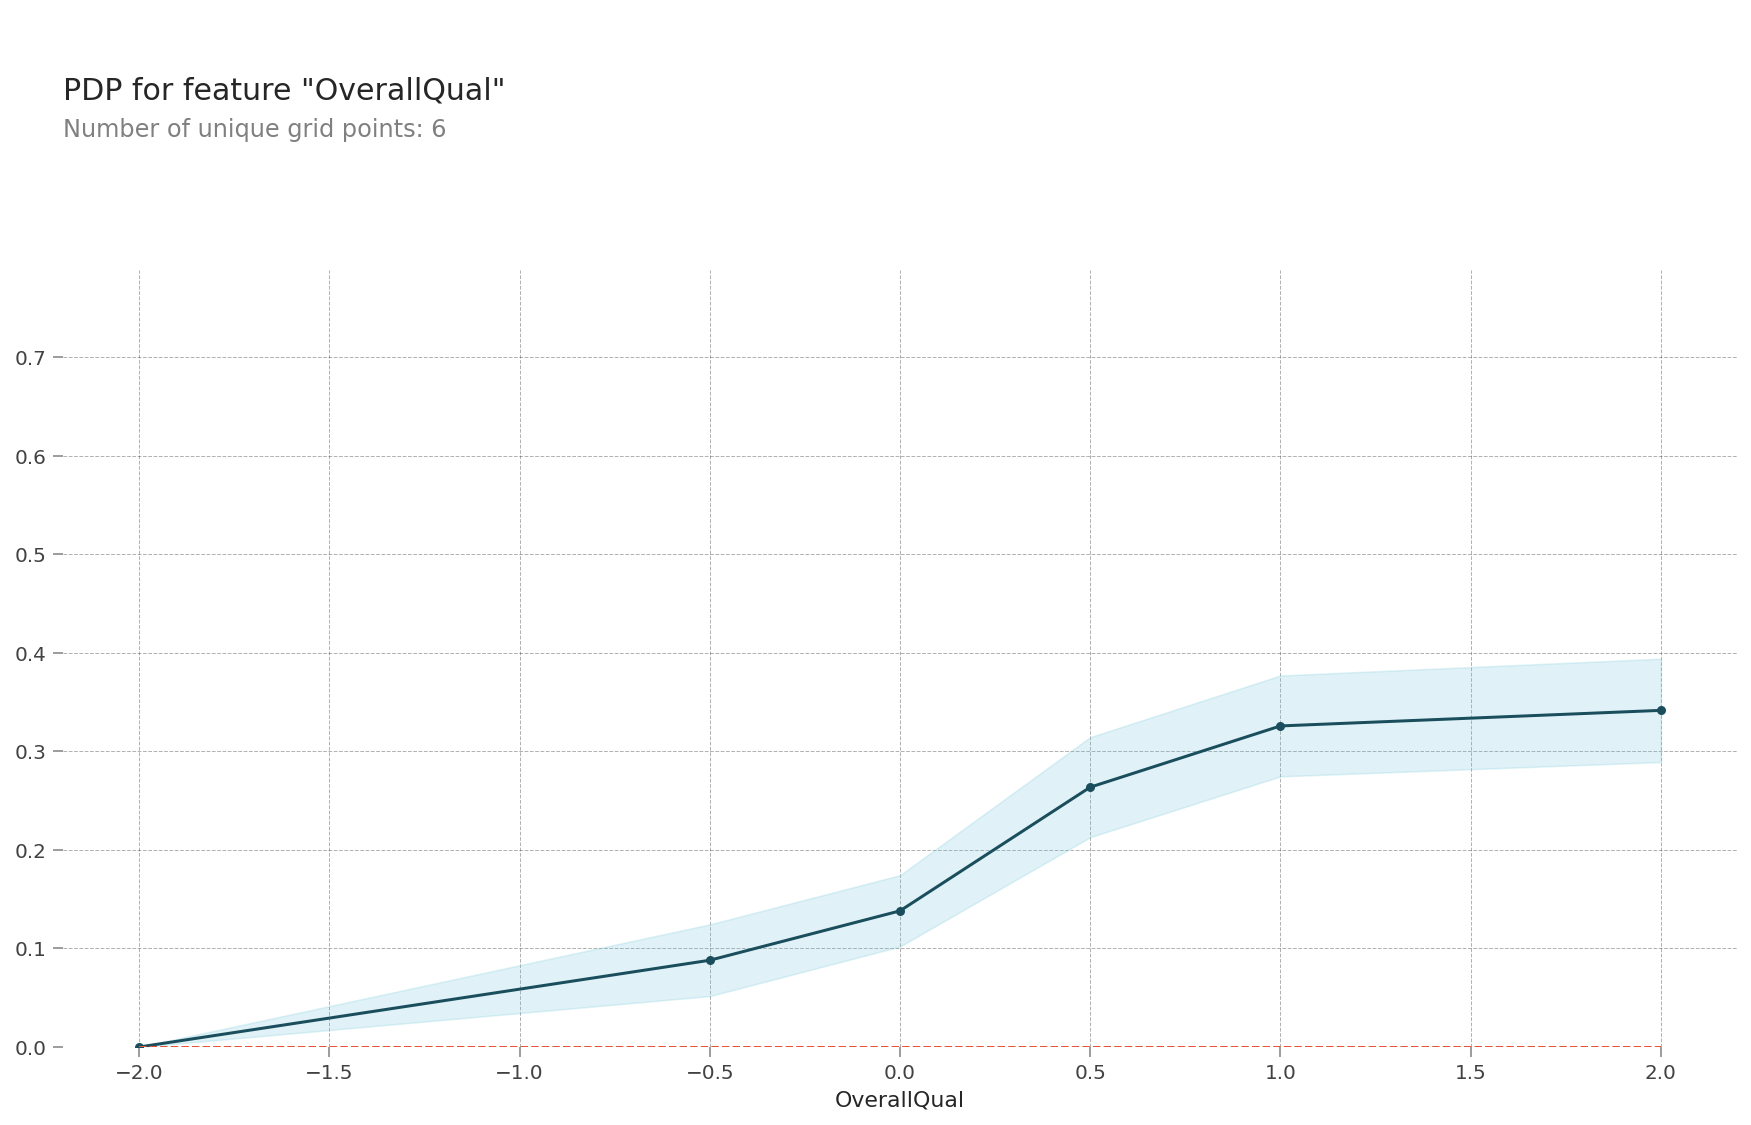

In [ ]:
pdp_plot(isolated, feature_name = 'OverallQual');

In [ ]:
isolated = pdp_isolate(
    model=boosting, 
    dataset=X_val_encoded, 
    model_features=X_val_encoded.columns, 
    feature = 'GrLivArea'
)

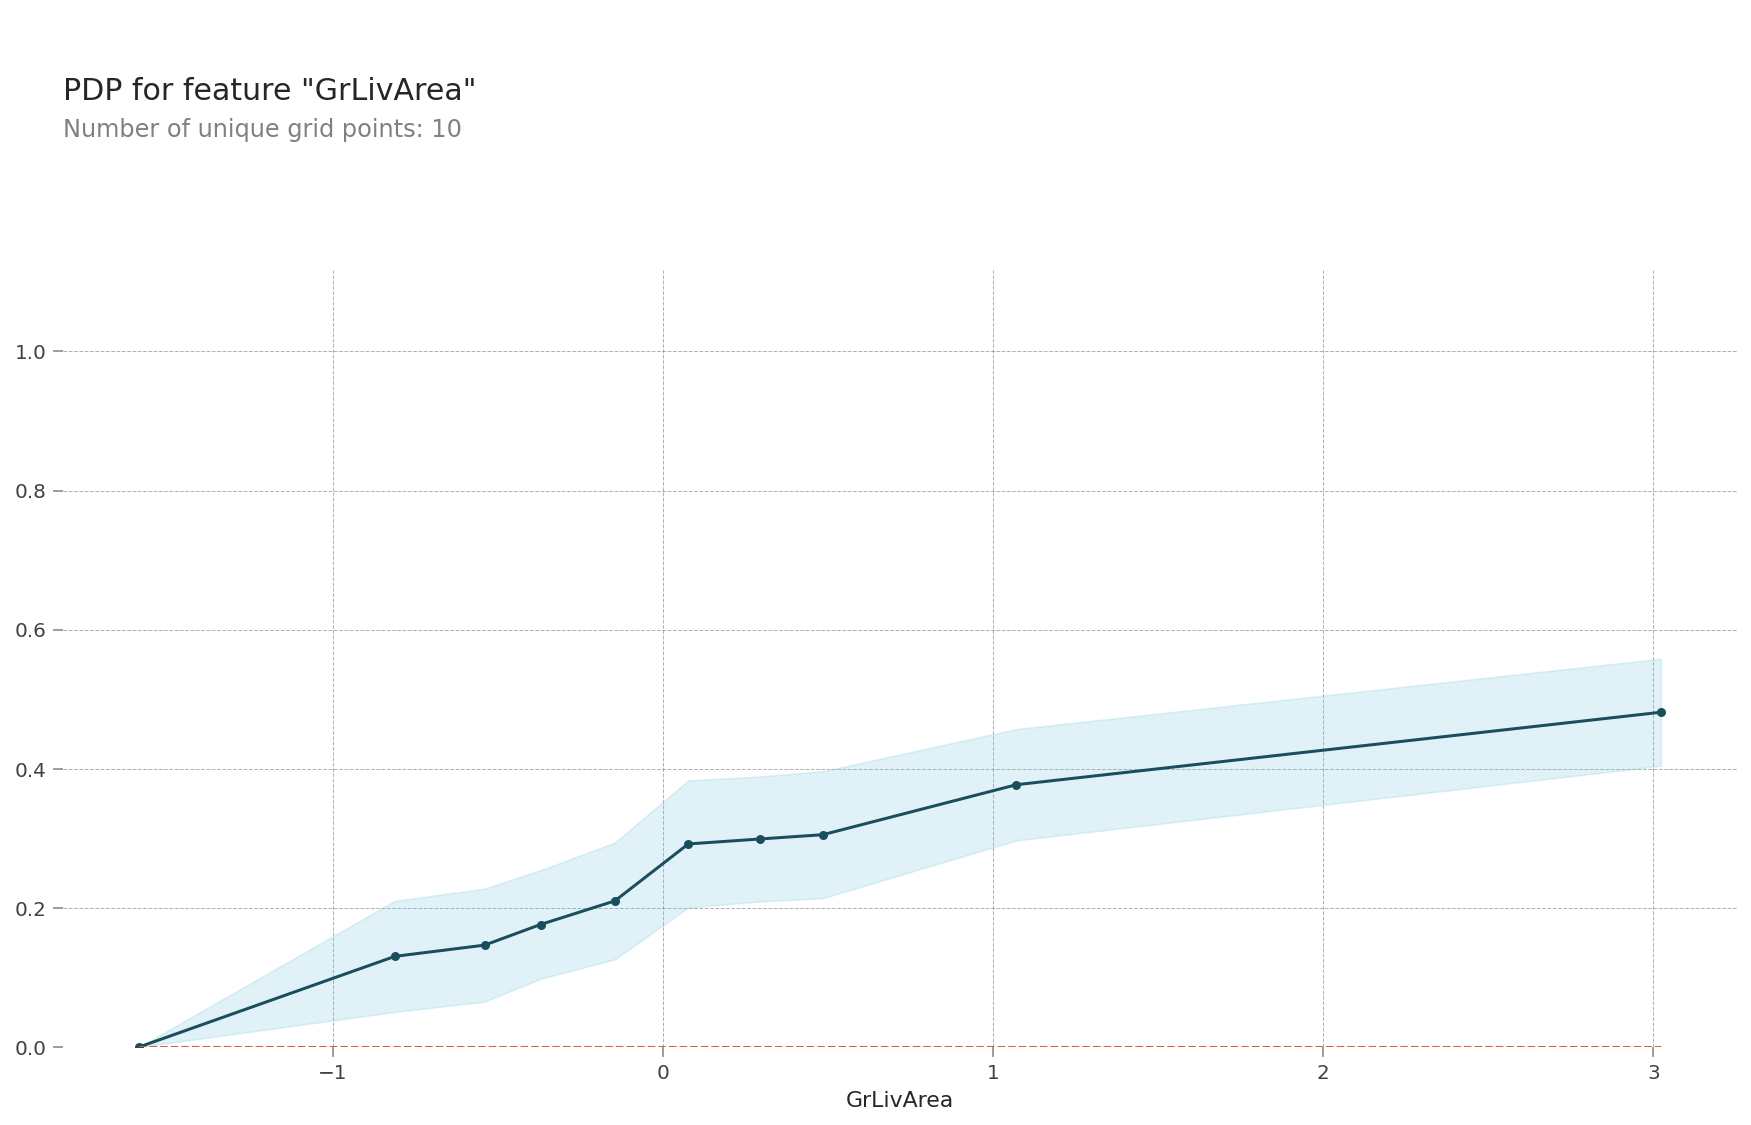

In [ ]:
pdp_plot(isolated, feature_name = 'GrLivArea');

# SHAP 결과물 작성

In [ ]:
## feature_SHAP = ['OverallQual','GrLivArea','GarageArea','TotalBsmtSF','FullBath','YearBuilt']

In [ ]:
## test1 = test[feature_SHAP]

In [ ]:
row = test.iloc[[1]]  # 중첩 brackets을 사용하면 결과물이 DataFrame입니다
row

,OverallQual,GrLivArea,GarageArea,TotalBsmtSF,FullBath,YearBuilt
Id,,,,,,
1462,0.0,-0.197973,-0.668008,0.691131,-1.0,-0.304348


In [ ]:
import xgboost
import numpy as np
import shap

In [ ]:
test1 = test.drop(columns=['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 'KitchenQual', 'FireplaceQu', 'GarageQual', 'Fence'])

In [ ]:
pred = boosting.predict(X_train_encoded)
explainer = shap.TreeExplainer(boosting)
shap_values = explainer.shap_values(X_train_encoded)
np.abs(shap_values.sum(1) + explainer.expected_value - pred).max()

2.002716e-05

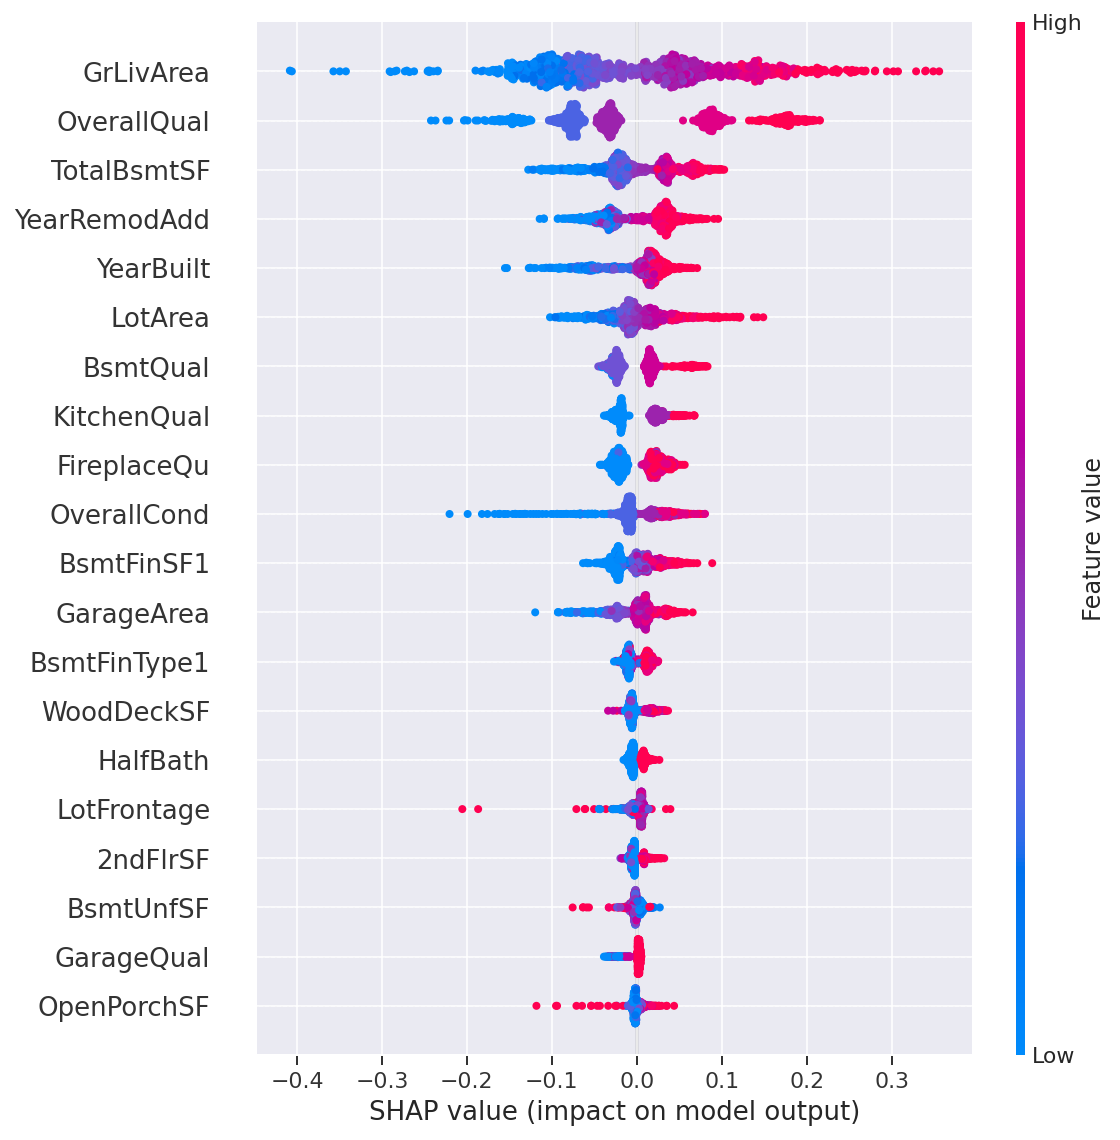

In [ ]:
shap.summary_plot(shap_values, X_train_encoded)

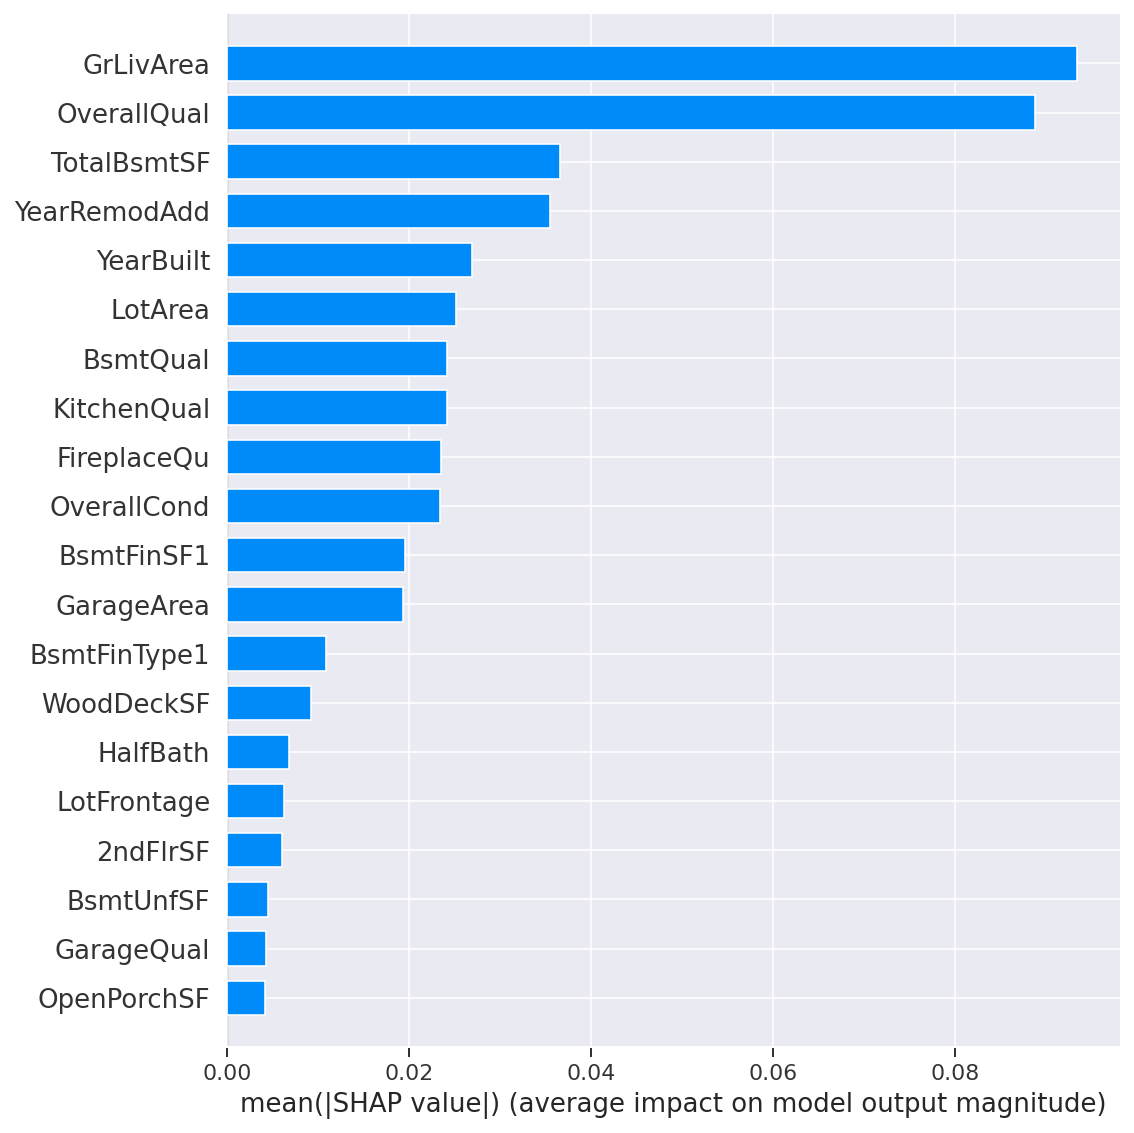

In [ ]:
shap.summary_plot(shap_values, X_train_encoded.iloc[:300], plot_type="bar")

In [ ]:
! pip install shap

     |████████████████████████████████| 358kB 35.1MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491636 sha256=6d2a749fb945b1b4e28aa4cf3ed311f283f7df6bf064aa8cd70c3b5ea67f059d
  Stored in directory: /root/.cache/pip/wheels/15/27/f5/a8ab9da52fd159aae6477b5ede6eaaec69fd130fa0fa59f283
Successfully built shap
